In [1]:
# IMPORT PACKAGES

# IMPORT
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import os
import sys
import us
from neuralforecast import NeuralForecast
from neuralforecast.models import Autoformer
from neuralforecast.losses.pytorch import MAE
import requests
import certifi
from io import StringIO
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
import itertools

import math
from typing import List, Optional, Tuple
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats


from fredapi import Fred
import pandas as pd
from fredapi import Fred
import pandas as pd

fred = Fred(api_key='f9a44139decd5e780297cade865dd2eb')



warnings.filterwarnings('ignore')


In [ ]:
# COVID-19 Data (daily reports)
#Estifanos
def getData(column='Confirmed', startDate="04-12-2020", endDate="03-09-2023"):
    try:
        minDate = datetime.strptime("04-12-2020", "%m-%d-%Y")
        maxDate = datetime.strptime("03-09-2023", "%m-%d-%Y")
        startDateTime = max(datetime.strptime(startDate, "%m-%d-%Y"), minDate)
        endDateTime = min(datetime.strptime(endDate, "%m-%d-%Y"), maxDate)
    except Exception as e:
        print("Error parsing dates:", e)
        return None

    all_data = []
    all_dates = []
    provinces_union = set()

    #Load all CSVs and collect data
    for offset in range((endDateTime - startDateTime).days + 1):
        day = startDateTime + timedelta(days=offset)
        url = (
            "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"
            "csse_covid_19_data/csse_covid_19_daily_reports_us/"
            + day.strftime("%m-%d-%Y") + ".csv"
        )
        try:
            
            #column=['Deaths', 'Recovered', 'Active']
            df = pd.read_csv(url)
            if column not in df.columns:
                print(f"{day.strftime('%m-%d-%Y')} missing '{column}' column.")
                continue
            df = df[['Province_State', column]].rename(columns={column: day.strftime("%m-%d-%Y")})
            all_data.append(df)
            all_dates.append(day.strftime("%m-%d-%Y"))
            provinces_union.update(df['Province_State'])

            """
            requested_cols = ['Deaths', 'Recovered', 'Active']
            df = pd.read_csv(url)

            # Filter to existing requested columns
            existing_cols = [c for c in requested_cols if c in df.columns]
            
            if not existing_cols:
                print(f"{day.strftime('%m-%d-%Y')} missing all requested columns: {requested_cols}")
                continue

            # Select Province_State plus existing columns
            df = df[['Province_State'] + existing_cols]

            # Rename: append date suffix to each metric column
            rename_map = {
                c: f"{c}_{day.strftime('%m-%d-%Y')}" for c in existing_cols
            }
            df.rename(columns=rename_map, inplace=True)

            # Append results
            all_data.append(df)
            all_dates.append(day.strftime("%m-%d-%Y"))
            provinces_union.update(df['Province_State'])
            """
        except Exception as e:
            print(f"Skipping {day.strftime('%m-%d-%Y')} — {type(e).__name__}: {e}")
            continue

    if not all_data:
        print("No data loaded.")
        return None

    #Merge all dataframes by Province_State
    full_df = pd.DataFrame({'Province_State': sorted(provinces_union)})
    for df in all_data:
        full_df = full_df.merge(df, on='Province_State', how='left')

    #Convert columns to numeric
    for col in full_df.columns[1:]:
        full_df[col] = pd.to_numeric(full_df[col], errors='coerce')

    print(f"Successfully loaded {len(all_data)} file(s) covering {all_dates[0]} → {all_dates[-1]}")
    return full_df




Successfully loaded 1062 file(s) covering 04-12-2020 → 03-09-2023
                2020-04-12  2020-04-13  2020-04-14  2020-04-15  2020-04-16  \
Province_State                                                               
Alabama                 93          99         114         118         133   
Alaska                   8           8           9           9           9   
American Samoa           0           0           0           0           0   
Arizona                115         122         131         142         150   
Arkansas                27          29          32          33          37   

                2020-04-17  2020-04-18  2020-04-19  2020-04-20  2020-04-21  \
Province_State                                                               
Alabama                148         153         157         163         183   
Alaska                   9           9           9           9           9   
American Samoa           0           0           0           0           0 

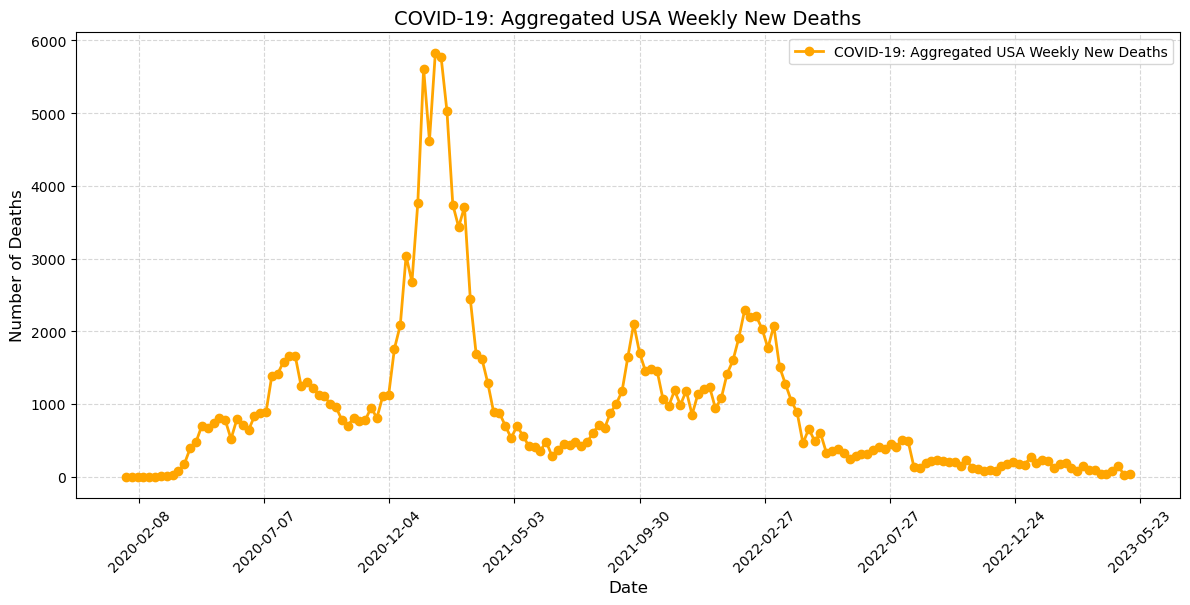

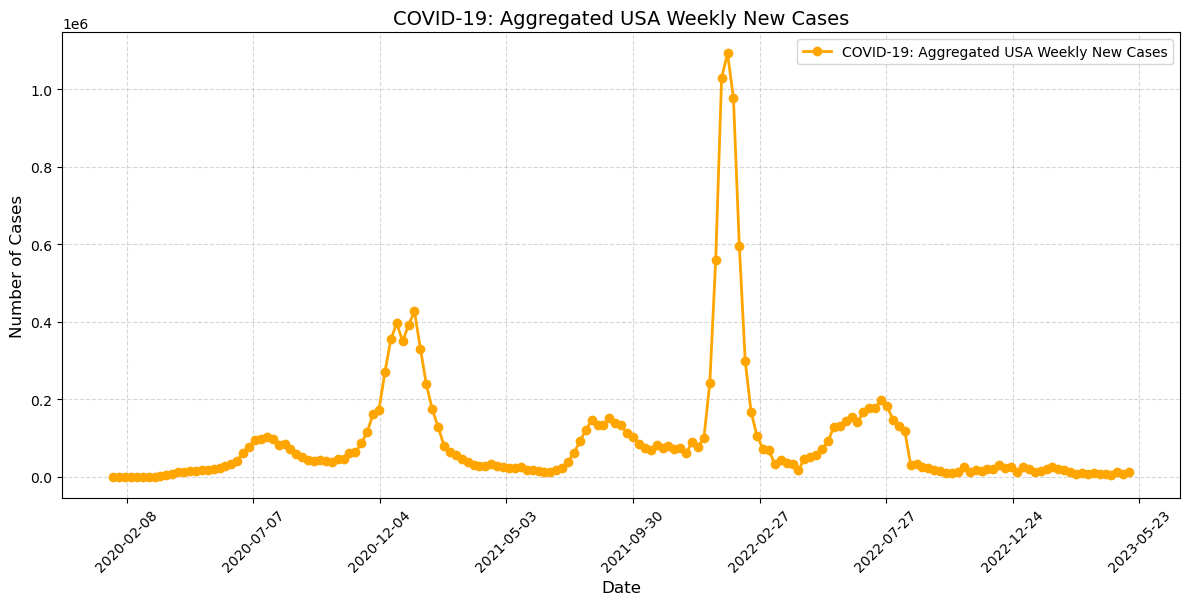

In [ ]:


# COVID-19 U.S. Daily Reports — Data Documentation
# Source (JHU CSSE):
# https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/04-30-2020.csv
# https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/03-11-2021.csv
#
# Columns included (per state):
# Province_State, Country_Region, Last_Update, Lat, Long_,
# Confirmed, Deaths, Recovered, Active, FIPS, Incident_Rate,
# Total_Test_Results, People_Hospitalized, Case_Fatality_Ratio,
# UID, ISO3, Testing_Rate, Hospitalization_Rate, Date,
# People_Tested, Mortality_Rate
#
# Subset used here:
# Province (state), Confirmed on 04-30-2020, Confirmed on 03-11-2021


#Estifanos
df = getData(column='Deaths')

df.columns = ['Province_State'] + list(pd.to_datetime(df.columns[1:], format="%m-%d-%Y"))

df = df.set_index('Province_State')

print(df.head())

newYork = df.loc['New York'] 


df_sum = (
    df.drop(columns=['Province_State'], errors='ignore')
      .sum()
      .reset_index()
      .rename(columns={'index': 'Date', 0: 'Total_Confirmed'})
)

df_mean = (
    df.drop(columns=['Province_State', 'Province'], errors='ignore')
      .select_dtypes(include='number')                  
      .mean()                                           
      .reset_index()
      .rename(columns={'index': 'Date', 0: 'Average_Confirmed'})
)

print(df_mean.head())

url = "https://data.cdc.gov/resource/pwn4-m3yp.csv"

response = requests.get(url, verify=certifi.where())
response.raise_for_status()

covid_cdc = pd.read_csv(StringIO(response.text))

print("Loaded:", covid_cdc.shape)
print(covid_cdc.head())



first_col = covid_cdc.columns[0]
print("Aggregating by:", first_col)

byState = covid_cdc.groupby(first_col).sum(numeric_only=True)

byState.columns
byState.index = pd.to_datetime(byState.index)


plt.figure(figsize=(12, 6))
plt.plot(
    byState.index,
    byState['new_deaths'],
    color='orange',
    linewidth=2,
    marker='o',
    label='COVID-19: Aggregated USA Weekly New Deaths'
)

plt.title("COVID-19: Aggregated USA Weekly New Deaths", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Deaths", fontsize=12)
plt.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))

plt.show()



plt.figure(figsize=(12, 6))
plt.plot(
    byState.index,
    byState['new_cases'],
    color='orange',
    linewidth=2,
    marker='o',
    label='COVID-19: Aggregated USA Weekly New Cases'
)

plt.title("COVID-19: Aggregated USA Weekly New Cases", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Cases", fontsize=12)
plt.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))

plt.show()

In [ ]:
#full import OF DATASET

#Estifanos
def fix_date(date_str):
    try:
        # parse MM-DD-YYYY
        d = dt.datetime.strptime(date_str, "%m-%d-%Y")
    except ValueError:
        raise ValueError(f"Invalid date format: {date_str}. Expected MM-DD-YYYY.")
    
    # Return in FRED format
    return d.strftime("%Y-%m-%d")

    
def getCombinedData(state='NY', column='Confirmed', startDate="04-12-2020", endDate="03-09-2023"):
    # Convert a state abbreviation to the full state name (for example, "NY" to "New York")
    full_name = us.states.lookup(state)
    if full_name is None:
        raise ValueError(f"Invalid state abbreviation: {state}")
    full_name = full_name.name

    # Build the FRED series ID for unemployment claims (for example, "NYICLAIMS")
    series_id = f'{state}ICLAIMS'

    # Convert dates from MM-DD-YYYY to the required FRED format YYYY-MM-DD
    observation_start = fix_date(startDate)
    observation_end   = fix_date(endDate)

    # Retrieve the unemployment claims time series from FRED
    claim = fred.get_series(series_id,
                            observation_start=observation_start,
                            observation_end=observation_end)

    # Retrieve the COVID time series for all states
    df = getData(column, startDate, endDate)

    # Convert all date columns to datetime objects and set Province_State as the index
    df.columns = ['Province_State'] + list(pd.to_datetime(df.columns[1:], format="%m-%d-%Y"))
    df = df.set_index('Province_State')

    # Extract the COVID time series for the selected state
    congruentDF = df.loc[full_name]

    # Combine the unemployment claims and COVID series using only the dates that appear in both
    joined = pd.concat([claim, congruentDF], axis=1, join='inner')
    joined.columns = ['claims', column]  # Rename columns for clarity

    return joined

def build_state_combined_data(state, extra_columns=['Deaths', 'Recovered', 'Active']):
   

    # Base data 
    final_df = getCombinedData(state=state).set_index('claims', append=True)

    # Fetch each extra metric one by one and join
    for col in extra_columns:
        try:
            temp_df = getCombinedData(state=state, column=col).set_index('claims', append=True)
            final_df = final_df.join(temp_df, how='inner')
        except Exception as e:
            print(f"Warning: {col} missing for {state} — SKIPPED ({type(e).__name__})")

    # Reset index and rename first two columns
    final_df = final_df.reset_index()
    final_df.rename(columns={final_df.columns[0]: 'Date', final_df.columns[1]: 'claims'}, inplace=True)

   
    final_df.set_index('Date', inplace=True)
    # Add state name
    final_df['Province_State'] = state

    # Weekly new cases & deaths
    final_df['New_Weekly_Cases'] = final_df['Confirmed'].diff().fillna(0)
    final_df['New_Weekly_Deaths'] = final_df['Deaths'].diff().fillna(0)

    # Reorder columns (optional)
    cols = ['Date', 'Province_State', 'claims', 'Confirmed', 'Deaths', 
        'New_Weekly_Cases', 'New_Weekly_Deaths', 'Recovered', 'Active']
    # Only keep columns that exist (Recovered/Active may be missing)
    final_df = final_df[[col for col in cols if col in final_df.columns]]

    # Save to CSV
    output_name = f"Final_{state}_CombinedData.csv"
    final_df.to_csv(output_name, index=True)

    print(f"Saved combined data → {output_name}")
    return final_df



def build_multiple_states(states, extra_columns=['Deaths', 'Recovered', 'Active']):
    """ Accepts a single state string or a list of state abbreviations. """
    
    # Normalize input to always be a list
    if isinstance(states, str):
        states = [states]

    results = {}

    for st in states:
        print(f"\nProcessing: {st}")
        results[st] = build_state_combined_data(st, extra_columns)

    print("\n✔ Done with all states!")
    return results



if __name__ == "__main__":
    # Choose the states 
    states_to_build = ['NY', 'FL','GA']

    # Build multiple states at once
    results = build_multiple_states(states_to_build)

    print("All states completed! Files saved:")
    #for state in results:
        #print(f"  Final_{state}_CombinedData.csv")

type(results)


Processing: NY


KeyboardInterrupt: 

In [ ]:
# Load files
#Trang Ly
FloridaFile = pd.read_csv("Final_FL_CombinedData.csv")
GeorgiaFile = pd.read_csv("Final_GA_CombinedData.csv")
NewYorkFile = pd.read_csv("Final_NY_CombinedData.csv")

# Convert Date to datetime and keep as a column
FloridaFile['Date'] = pd.to_datetime(FloridaFile['Date'])
GeorgiaFile['Date'] = pd.to_datetime(GeorgiaFile['Date'])
NewYorkFile['Date'] = pd.to_datetime(NewYorkFile['Date'])

# Keep only needed columns and rename with state prefixes
FloridaFile = FloridaFile[['Date', 'claims', 'Confirmed', 'Deaths']].rename(
    columns={'claims': 'FL_claims', 'Confirmed': 'FL_cases', 'Deaths': 'FL_deaths'}
)

GeorgiaFile = GeorgiaFile[['Date', 'claims', 'Confirmed', 'Deaths']].rename(
    columns={'claims': 'GA_claims', 'Confirmed': 'GA_cases', 'Deaths': 'GA_deaths'}
)

NewYorkFile = NewYorkFile[['Date', 'claims', 'Confirmed', 'Deaths']].rename(
    columns={'claims': 'NY_claims', 'Confirmed': 'NY_cases', 'Deaths': 'NY_deaths'}
)

# Merge all by Date
df = FloridaFile.merge(GeorgiaFile, on='Date', how='outer') \
                .merge(NewYorkFile, on='Date', how='outer')

# Rename Date column to lowercase
df = df.rename(columns={'Date': 'date'})

# Preview final DataFrame
print(df.head())
print(df.info())



        date  FL_claims  FL_cases  FL_deaths  GA_claims  GA_cases  GA_deaths  \
0 2020-04-18   506670.0   25492.0      748.0   247003.0   17669.0      673.0   
1 2020-04-25   433103.0   30839.0     1055.0   266565.0   23222.0      907.0   
2 2020-05-02   174860.0   35463.0     1364.0   228352.0   28331.0     1177.0   
3 2020-05-09   223082.0   40001.0     1715.0   242772.0   32588.0     1403.0   
4 2020-05-16   225404.0   44811.0     1964.0   177731.0   37212.0     1598.0   

   NY_claims  NY_cases  NY_deaths  
0   205184.0  241712.0    17634.0  
1   219413.0  282143.0    21933.0  
2   195110.0  312977.0    24090.0  
3   199419.0  333122.0    26499.0  
4   229524.0  348232.0    27922.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       151 non-null    datetime64[ns]
 1   FL_claims  151 non-null    float64       
 2   FL_ca

In [5]:
print(df.columns)


Index(['FL_claims', 'FL_cases', 'FL_deaths', 'GA_claims', 'GA_cases',
       'GA_deaths', 'NY_claims', 'NY_cases', 'NY_deaths'],
      dtype='object')


In [26]:
df = rr.copy()

In [ ]:
df = results["FL"]


NameError: name 'results' is not defined

In [24]:
df.head()

,Date,Province_State,claims,Confirmed,Deaths,New_Weekly_Cases,New_Weekly_Deaths,Recovered,Active
0,2020-04-18,NY,205184.0,241712.0,17634.0,0.0,0.0,23887.0,200191.0
1,2020-04-25,NY,219413.0,282143.0,21933.0,40431.0,4299.0,23887.0,236323.0
2,2020-05-02,NY,195110.0,312977.0,24090.0,30834.0,2157.0,57540.0,231347.0
3,2020-05-09,NY,199419.0,333122.0,26499.0,20145.0,2409.0,57180.0,249443.0
4,2020-05-16,NY,229524.0,348232.0,27922.0,15110.0,1423.0,60796.0,259514.0


In [25]:
df = df[[ 'claims', 'Confirmed', 'Deaths', 'Date' , 'Active']]
df.head()

,claims,Confirmed,Deaths,Date,Active
0,205184.0,241712.0,17634.0,2020-04-18,200191.0
1,219413.0,282143.0,21933.0,2020-04-25,236323.0
2,195110.0,312977.0,24090.0,2020-05-02,231347.0
3,199419.0,333122.0,26499.0,2020-05-09,249443.0
4,229524.0,348232.0,27922.0,2020-05-16,259514.0


In [17]:
df['ds'] = df.index

In [22]:
# Here prepare the train, val and test files.

#df = FinalFloridaCombinedData.copy()
#df = results["FL"]
#df['ds'] = df.index
df['unique_id'] = 'series_1'
df = df.rename(columns=lambda x: x.strip())  
try:
    df = df.drop(columns=['Unnamed: 0'])  
except:
    x =1 

df['ds'] = pd.to_datetime(df['Date'])
df = df.drop(columns=['Date'])
df['ds'] = pd.to_datetime(df['ds'].dt.date)

# Sometimes the first day is excluded; shift +1 day
df['ds'] = pd.to_datetime(df['ds']) + pd.to_timedelta(1, unit='D')

# Target column claims:
#df = df.rename(columns={'claims': 'y'})

# Target column 'Confirmed'
df = df.rename(columns={'Confirmed': 'y'})

# Target column 'Deaths'
#df = df.rename(columns={'Deaths': 'y'})


df = df.drop(columns=['Active'])

df['Date'] = df['ds']
# FUTURE EXOGENOUS VARIABLES
futr_cols = ['Deaths', 'Confirmed']  


n = len(df)
train = df.iloc[:int(n*0.7)]
val   = df.iloc[int(n*0.7):int(n*0.85)]
test  = df.iloc[int(n*0.85):]

print("Train:", train.shape)
print("Val:",   val.shape)
print("Test:",  test.shape)

train.head()


KeyError: 'Date'

In [7]:

n = len(df)
train = df.iloc[:int(n*0.7)]
val   = df.iloc[int(n*0.7):int(n*0.85)]
test  = df.iloc[int(n*0.85):]

print("Train:", train.shape)
print("Val:",   val.shape)
print("Test:",  test.shape)

Train: (105, 10)
Val: (23, 10)
Test: (23, 10)


In [8]:
train.head()

,date,FL_claims,FL_cases,FL_deaths,GA_claims,GA_cases,GA_deaths,NY_claims,NY_cases,NY_deaths
0,2020-04-18,506670.0,25492.0,748.0,247003.0,17669.0,673.0,205184.0,241712.0,17634.0
1,2020-04-25,433103.0,30839.0,1055.0,266565.0,23222.0,907.0,219413.0,282143.0,21933.0
2,2020-05-02,174860.0,35463.0,1364.0,228352.0,28331.0,1177.0,195110.0,312977.0,24090.0
3,2020-05-09,223082.0,40001.0,1715.0,242772.0,32588.0,1403.0,199419.0,333122.0,26499.0
4,2020-05-16,225404.0,44811.0,1964.0,177731.0,37212.0,1598.0,229524.0,348232.0,27922.0


In [ ]:
#ARIMAX BASE
#Trang Ly
print("="*80)
print("ARIMAX MODEL - SINGLE STATE WITH COVID FEATURES")
print("="*80)

# Load states list
#with open('states_list.txt', 'r') as f:
#    states = f.read().strip().split(',')

#print(f"\n Detected states: {states}")

states = ['FL','GA','NY']
# Load training and test data (wide format)
#train_data = pd.read_csv('train_data.csv')
#test_data = pd.read_csv('test_data.csv')

train_data = train.copy()
test_data = test.copy()

train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])

print(f"\nTrain data: {len(train_data)} weeks")
print(f"Test data: {len(test_data)} weeks")
print(f"Train date range: {train_data['date'].min()} to {train_data['date'].max()}")
print(f"Test date range: {test_data['date'].min()} to {test_data['date'].max()}")

# ============================================
# ARIMAX CONFIGURATION - GRID SEARCH with CV
# ============================================



def evaluate_arimax_model(y, exog, order, seasonal_order):
    """Evaluate ARIMAX model using time series cross-validation"""
    try:
        model = SARIMAX(y, exog=exog, order=order, 
                       seasonal_order=seasonal_order,
                       enforce_stationarity=False,
                       enforce_invertibility=False)
        fitted = model.fit(disp=False, maxiter=100)
        return fitted.aic, fitted.bic
    except:
        return np.inf, np.inf

# Grid search
p_range = range(0, 3)
d_range = range(0, 2)
q_range = range(0, 3)
P_range = range(0, 2)
D_range = range(0, 2)
Q_range = range(0, 2)
s = 52

best_aic = np.inf
best_order = None
best_seasonal = None

print("Grid searching for optimal order...")

for state in states:
    y = train_data[f'{state}_claims']
    X = train_data[[f'{state}_cases', f'{state}_deaths']]
    
    print(f"\nSearching for {state}...")
    
    
    orders_to_try = [
        ((1,1,1), (0,0,0,0)),  # Simple, no seasonal
        ((1,1,1), (1,0,1,52)), # Simple with seasonal
        ((2,1,2), (0,0,0,0)),  # Medium, no seasonal
        ((2,1,2), (1,0,1,52)), 
        ((3,1,3), (1,0,1,52)), # Complex
        ((1,1,0), (0,0,0,0)),  # AR only
        ((0,1,1), (0,0,0,0)),  # MA only
        ((2,1,0), (1,0,0,52)), # AR with seasonal AR
    ]
    
    for order, seasonal_order in orders_to_try:
        aic, bic = evaluate_arimax_model(y, X, order, seasonal_order)
        print(f"  {order} {seasonal_order}: AIC={aic:.0f}, BIC={bic:.0f}")
        
        if aic < best_aic:
            best_aic = aic
            best_order = order
            best_seasonal = seasonal_order
    
    print(f"\n Best for {state}: {best_order} {best_seasonal} (AIC: {best_aic:.0f})")

ARIMAX_CONFIG = {
    'order': best_order,
    'seasonal_order': best_seasonal,
    'enforce_stationarity': False,
    'enforce_invertibility': False,
    'maxiter': 200,
    'disp': False
}

print(f"\nARIMAX Configuration:")
print(f"  Order (p,d,q): {ARIMAX_CONFIG['order']}")
print(f"  Seasonal Order (P,D,Q,s): {ARIMAX_CONFIG['seasonal_order']}")

# ============================================
# FIT ARIMAX FOR EACH STATE
# ============================================

print(f"\n{'='*80}")
print("FITTING ARIMAX MODELS")
print(f"{'='*80}")

arimax_results = {}

for state in states:
    print(f"\n{'='*60}")
    print(f"STATE: {state}")
    print(f"{'='*60}")
    
    # Extract target variable (claims)
    y_train = train_data[f'{state}_claims'].copy()
    y_test = test_data[f'{state}_claims'].copy()
    
    # Extract exogenous variables (COVID features)
    X_train = train_data[[f'{state}_cases', f'{state}_deaths']].copy()
    X_test = test_data[[f'{state}_cases', f'{state}_deaths']].copy()
    
    print(f"\nTarget variable: {state}_claims")
    print(f"  Train size: {len(y_train)}")
    print(f"  Test size: {len(y_test)}")
    
    print(f"\nExogenous variables: {X_train.columns.tolist()}")
    print(f"  Train shape: {X_train.shape}")
    print(f"  Test shape: {X_test.shape}")
    
    # FIXED: Check for missing values correctly (both lines)
    train_missing = y_train.isnull().sum() + X_train.isnull().sum().sum()
    if train_missing > 0:
        print(f"\n WARNING: {train_missing} missing values in training data")
        print(f"  y_train missing: {y_train.isnull().sum()}")
        print(f"  X_train missing:\n{X_train.isnull().sum()}")
        print("Filling with forward fill...")
        y_train = y_train.fillna(method='ffill')
        X_train = X_train.fillna(method='ffill')
    
    test_missing = y_test.isnull().sum() + X_test.isnull().sum().sum()
    if test_missing > 0:
        print(f"\n WARNING: {test_missing} missing values in test data")
        print(f"  y_test missing: {y_test.isnull().sum()}")
        print(f"  X_test missing:\n{X_test.isnull().sum()}")
        print("Filling with forward fill...")
        y_test = y_test.fillna(method='ffill')
        X_test = X_test.fillna(method='ffill')
    
    try:
        print(f"\nFitting ARIMAX model...")
            
        model = SARIMAX(
            y_train,
            exog=X_train,
            order=ARIMAX_CONFIG['order'],
            seasonal_order=ARIMAX_CONFIG['seasonal_order'],
            enforce_stationarity=ARIMAX_CONFIG['enforce_stationarity'],
            enforce_invertibility=ARIMAX_CONFIG['enforce_invertibility']
        )
        
        fitted_model = model.fit(
            disp=ARIMAX_CONFIG['disp'],
            maxiter=ARIMAX_CONFIG['maxiter']
        )
        
        print(f" Model fitted successfully")
        
        # Make predictions
        print(f"\nGenerating forecasts...")
        forecast = fitted_model.forecast(steps=len(test_data), exog=X_test)
        
        # Calculate metrics
        mae = mean_absolute_error(y_test, forecast)
        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        
        smape = np.mean(2 * np.abs(forecast - y_test) / (np.abs(y_test) + np.abs(forecast))) * 100
        r2 = r2_score(y_test, forecast)
        
        # Direction accuracy
        actual_direction = np.sign(np.diff(y_test.values))
        pred_direction = np.sign(np.diff(forecast.values))
        direction_acc = np.mean(actual_direction == pred_direction) * 100
        
        # Store results
        arimax_results[state] = {
            'model': fitted_model,
            'forecast': forecast,
            'actual': y_test,
            'train_dates': train_data['date'],
            'test_dates': test_data['date'],
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': smape,
            'R2': r2,
            'Direction_Acc': direction_acc,
            'AIC': fitted_model.aic,
            'BIC': fitted_model.bic
        }
        
        # Print results
        print(f"\n{'='*60}")
        print(f"RESULTS FOR {state}")
        print(f"{'='*60}")
        print(f"  MAE:                {mae:,.0f}")
        print(f"  RMSE:               {rmse:,.0f}")
        print(f"  MAPE:               {smape:.2f}%")
        print(f"  R²:                 {r2:.3f}")
        print(f"  Direction Accuracy: {direction_acc:.1f}%")
        print(f"  AIC:                {fitted_model.aic:.0f}")
        print(f"  BIC:                {fitted_model.bic:.0f}")
        
        print(f"\n  Converged: {fitted_model.mle_retvals['converged']}")
        
    except Exception as e:
        print(f"\n ERROR: ARIMAX failed for {state}")
        print(f"   {str(e)}")
        print(f"\n   Trying simpler model specification...")
        
        try:
            model_simple = SARIMAX(
                y_train,
                exog=X_train,
                order=(1, 1, 1),
                seasonal_order=(0, 0, 0, 0),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            
            fitted_model = model_simple.fit(disp=False, maxiter=100)
            forecast = fitted_model.forecast(steps=len(test_data), exog=X_test)
            
            mae = mean_absolute_error(y_test, forecast)
            rmse = np.sqrt(mean_squared_error(y_test, forecast))
            
            # Replace MAPE calculation with SMAPE
            smape = np.mean(2 * np.abs(forecast - y_test) / (np.abs(y_test  ) + np.abs(forecast))) * 100
            r2 = r2_score(y_test, forecast)
            
            actual_direction = np.sign(np.diff(y_test.values))
            pred_direction = np.sign(np.diff(forecast.values))
            direction_acc = np.mean(actual_direction == pred_direction) * 100
            
            arimax_results[state] = {
                'model': fitted_model,
                'forecast': forecast,
                'actual': y_test,
                'train_dates': train_data['date'],
                'test_dates': test_data['date'],
                'MAE': mae,
                'RMSE': rmse,
                'MAPE': smape,
                'R2': r2,
                'Direction_Acc': direction_acc,
                'AIC': fitted_model.aic,
                'BIC': fitted_model.bic,
                'note': 'Simplified model (1,1,1) with no seasonality'
            }
            
            print(f" Simpler model fitted successfully")
            print(f"  MAE: {mae:,.0f}, RMSE: {rmse:,.0f}, R²: {r2:.3f}")
            
        except Exception as e2:
            print(f"   Simpler model also failed: {str(e2)}")
            arimax_results[state] = None

# ============================================
# SAVE RESULTS
# ============================================

print(f"\n{'='*80}")
print("SAVING RESULTS")
print(f"{'='*80}")

summary_data = []

for state in states:
    if arimax_results.get(state):
        result = arimax_results[state]
        summary_data.append({
            'State': state,
            'Model': 'ARIMAX',
            'MAE': result['MAE'],
            'RMSE': result['RMSE'],
            'MAPE': result['MAPE'],
            'R2': result['R2'],
            'Direction_Acc': result['Direction_Acc'],
            'AIC': result['AIC'],
            'BIC': result['BIC'],
            'Note': result.get('note', 'Full model')
        })

summary_df = pd.DataFrame(summary_data)

print("\n" + "="*80)
print("ARIMAX SUMMARY - ALL STATES")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)

summary_df.to_csv('arimax_results.csv', index=False)
print(f"\n Saved 'arimax_results.csv'")

# Save individual forecasts
for state in states:
    if arimax_results.get(state):
        forecast_df = pd.DataFrame({
            'date': test_data['date'],
            'actual': arimax_results[state]['actual'].values,
            'forecast': arimax_results[state]['forecast'].values,
            'error': arimax_results[state]['actual'].values - arimax_results[state]['forecast'].values
        })
        forecast_df.to_csv(f'arimax_forecast_{state}.csv', index=False)
        print(f" Saved 'arimax_forecast_{state}.csv'")

# ============================================
# VISUALIZATION
# ============================================

print(f"\n{'='*80}")
print("VISUALIZATIONS")
print(f"{'='*80}")

n_states = len([s for s in states if arimax_results.get(s)])

if n_states > 0:
    fig, axes = plt.subplots(n_states, 2, figsize=(16, 5*n_states))

    if n_states == 1:
        axes = axes.reshape(1, -1)

    plot_idx = 0

    for state in states:
        if not arimax_results.get(state):
            continue
        
        result = arimax_results[state]
        
        # Left: Actual vs Forecast
        ax1 = axes[plot_idx, 0]
        
        ax1.plot(result['train_dates'], train_data[f'{state}_claims'],
                 color='gray', alpha=0.3, linewidth=1, label='Training Data')
        
        ax1.plot(result['test_dates'], result['actual'],
                 color='lightblue', linewidth=2.5, marker='o', markersize=5,
                 label='Actual', zorder=3)
        
        ax1.plot(result['test_dates'], result['forecast'],
                 color='red', linewidth=2.5, marker='s', markersize=4,
                 linestyle='--', label='ARIMAX Forecast', alpha=0.8, zorder=2)
        
        ax1.axvline(result['train_dates'].max(), color='blue', 
                    linestyle='--', linewidth=2, alpha=0.5, label='Train/Test Split')
        
        ax1.set_title(f'{state} - ARIMAX Forecast vs Actual\n' + 
                      f'MAE: {result["MAE"]:,.0f} | RMSE: {result["RMSE"]:,.0f} | R²: {result["R2"]:.3f}',
                      fontsize=14, fontweight='bold')
        ax1.set_xlabel('Date', fontsize=12)
        ax1.set_ylabel('Unemployment Claims (thousands)', fontsize=12)
        ax1.legend(loc='best', fontsize=10)
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='x', rotation=45)
        
        # Right: Errors
        ax2 = axes[plot_idx, 1]
        
        errors = result['actual'].values - result['forecast'].values
        
        ax2.plot(result['test_dates'], errors, 
                 color='purple', linewidth=2, marker='o', markersize=4)
        ax2.axhline(0, color='black', linestyle='-', linewidth=1)
        ax2.axhline(errors.mean(), color='red', linestyle='--', 
                    linewidth=2, label=f'Mean Error: {errors.mean():,.0f}')
        
        std_error = errors.std()
        ax2.fill_between(result['test_dates'], -std_error, std_error,
                         alpha=0.2, color='gray', label=f'±1 Std: {std_error:,.0f}')
        
        ax2.set_title(f'{state} - Forecast Errors\n' + 
                      f'Mean: {errors.mean():,.0f} | Std: {errors.std():,.0f}',
                      fontsize=14, fontweight='bold')
        ax2.set_xlabel('Date', fontsize=12)
        ax2.set_ylabel('Forecast Error', fontsize=12)
        ax2.legend(loc='best', fontsize=10)
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(axis='x', rotation=45)
        
        plot_idx += 1

    plt.tight_layout()
    plt.savefig('arimax_forecasts.png', dpi=300, bbox_inches='tight')
    print(f" Saved 'arimax_forecasts.png'")
    plt.close()

# ============================================
# RESIDUAL DIAGNOSTICS
# ============================================

print(f"\n{'='*80}")
print("RESIDUAL DIAGNOSTICS")
print(f"{'='*80}")

if n_states > 0:
    fig, axes = plt.subplots(n_states, 2, figsize=(16, 5*n_states))

    if n_states == 1:
        axes = axes.reshape(1, -1)

    plot_idx = 0

    for state in states:
        if not arimax_results.get(state):
            continue
        
        result = arimax_results[state]
        residuals = result['model'].resid
        
        # Histogram
        ax1 = axes[plot_idx, 0]
        ax1.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
        ax1.axvline(0, color='red', linestyle='--', linewidth=2)
        ax1.set_title(f'{state} - Residual Distribution', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Residuals')
        ax1.set_ylabel('Frequency')
        ax1.grid(True, alpha=0.3)
        
        # Q-Q plot
        
        ax2 = axes[plot_idx, 1]
        stats.probplot(residuals, dist="norm", plot=ax2)
        ax2.set_title(f'{state} - Q-Q Plot', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        
        plot_idx += 1

    plt.tight_layout()
    plt.savefig('arimax_diagnostics.png', dpi=300, bbox_inches='tight')
    print(f" Saved 'arimax_diagnostics.png'")
    plt.close()

# ============================================
# FINAL SUMMARY
# ============================================

print(f"\n{'='*80}")
print("ARIMAX MODELING COMPLETE")
print(f"{'='*80}")

successful_states = len([s for s in states if arimax_results.get(s)])
print(f"\n Successfully modeled {successful_states} / {len(states)} states")

if successful_states > 0:
    print(f"\n PERFORMANCE SUMMARY:")
    for state in states:
        if arimax_results.get(state):
            result = arimax_results[state]
            print(f"\n  {state}:")
            print(f"    MAE:  {result['MAE']:>10,.0f}")
            print(f"    RMSE: {result['RMSE']:>10,.0f}")
            print(f"    R²:   {result['R2']:>10.3f}")
            print(f"    MAPE: {result['MAPE']:>10.2f}%")

    print(f"\n FILES CREATED:")
    print(f"    arimax_results.csv")
    for state in states:
        if arimax_results.get(state):
            print(f"    arimax_forecast_{state}.csv")
    print(f"    arimax_forecasts.png")
    print(f"    arimax_diagnostics.png")


ARIMAX MODEL - SINGLE STATE WITH COVID FEATURES

Train data: 105 weeks
Test data: 23 weeks
Train date range: 2020-04-18 00:00:00 to 2022-04-16 00:00:00
Test date range: 2022-10-01 00:00:00 to 2023-03-04 00:00:00
Grid searching for optimal order...

Searching for FL...
  (1, 1, 1) (0, 0, 0, 0): AIC=2260, BIC=2273
  (1, 1, 1) (1, 0, 1, 52): AIC=1069, BIC=1082
  (2, 1, 2) (0, 0, 0, 0): AIC=2232, BIC=2250
  (2, 1, 2) (1, 0, 1, 52): AIC=1024, BIC=1041
  (3, 1, 3) (1, 0, 1, 52): AIC=974, BIC=995
  (1, 1, 0) (0, 0, 0, 0): AIC=2424, BIC=2434
  (0, 1, 1) (0, 0, 0, 0): AIC=2258, BIC=2269
  (2, 1, 0) (1, 0, 0, 52): AIC=1066, BIC=1077

 Best for FL: (3, 1, 3) (1, 0, 1, 52) (AIC: 974)

Searching for GA...
  (1, 1, 1) (0, 0, 0, 0): AIC=2193, BIC=2206
  (1, 1, 1) (1, 0, 1, 52): AIC=906, BIC=919
  (2, 1, 2) (0, 0, 0, 0): AIC=2121, BIC=2140
  (2, 1, 2) (1, 0, 1, 52): AIC=981, BIC=998
  (3, 1, 3) (1, 0, 1, 52): AIC=952, BIC=973
  (1, 1, 0) (0, 0, 0, 0): AIC=2207, BIC=2218
  (0, 1, 1) (0, 0, 0, 0): AIC=2

In [ ]:
#ARIMAX INTERVENTION
#Trang Ly
"""
ARIMAX with Intervention Analysis
Purpose: Explicitly model pandemic policy interventions
Methods: Add intervention dummy variables for:
  - Initial shutdown
  - Reopening
  - Delta/Omicron waves
  - Vaccine rollout
"""

# Create output directory
os.makedirs('Results/intervention', exist_ok=True)

print("="*80)
print("ARIMAX WITH INTERVENTION ANALYSIS")
print("="*80)

# ============================================
# LOAD DATA
# ============================================

print("\nLoading data...")
#train_data = pd.read_csv('train_data.csv')
#test_data = pd.read_csv('test_data.csv')
train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])

#with open('states_list.txt', 'r') as f:
#    states = f.read().strip().split(',')

print(f"States: {states}")
print(f"Train: {len(train_data)} weeks ({train_data['date'].min()} to {train_data['date'].max()})")
print(f"Test: {len(test_data)} weeks ({test_data['date'].min()} to {test_data['date'].max()})")

# ============================================
# DEFINE INTERVENTION PERIODS
# ============================================

# Key pandemic intervention periods
interventions = {
    'initial_shutdown': ('2020-03-15', '2020-05-31'),
    'reopening': ('2020-06-01', '2020-08-31'),
    'second_wave': ('2020-11-01', '2021-02-28'),
    'vaccine_rollout': ('2021-01-01', '2021-06-30'),
    'delta_wave': ('2021-07-01', '2021-10-31'),
    'omicron_wave': ('2021-12-01', '2022-02-28')
}

print(f"\n{'='*80}")
print("DEFINED INTERVENTION PERIODS")
print(f"{'='*80}")
for name, (start, end) in interventions.items():
    print(f"  {name:20s}: {start} to {end}")

# ============================================
# CREATE INTERVENTION DUMMIES
# ============================================

def create_intervention_dummies(dates, interventions):
    """Create dummy variables for each intervention period"""
    
    dummies = pd.DataFrame(index=dates.index)
    
    for name, (start, end) in interventions.items():
        start_date = pd.to_datetime(start)
        end_date = pd.to_datetime(end)
        
        dummies[name] = ((dates >= start_date) & (dates <= end_date)).astype(int)
    
    return dummies

# Create intervention dummies for train and test
train_interventions = create_intervention_dummies(train_data['date'], interventions)
test_interventions = create_intervention_dummies(test_data['date'], interventions)

print(f"\nCreated {len(interventions)} intervention dummy variables")
print(f"\nTrain intervention counts (weeks in each period):")
print(train_interventions.sum())

# ============================================
# VISUALIZE INTERVENTIONS
# ============================================

print(f"\n{'='*80}")
print("CREATING INTERVENTION VISUALIZATION")
print(f"{'='*80}")

fig, axes = plt.subplots(len(states), 1, figsize=(16, 5*len(states)))

if len(states) == 1:
    axes = [axes]

for idx, state in enumerate(states):
    ax = axes[idx]
    
    # Plot claims
    ax.plot(train_data['date'], train_data[f'{state}_claims'],
            linewidth=2, label='Unemployment Claims', color='blue', zorder=5)
    
    # Shade intervention periods
    colors = ['red', 'orange', 'yellow', 'green', 'cyan', 'purple']
    for (name, (start, end)), color in zip(interventions.items(), colors):
        start_date = pd.to_datetime(start)
        end_date = pd.to_datetime(end)
        
        # Shade the intervention period
        ax.axvspan(start_date, end_date, alpha=0.3, color=color, label=name)
    
    ax.set_title(f'{state} - Unemployment Claims with Intervention Periods', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Unemployment Claims (thousands)', fontsize=12)
    ax.legend(loc='upper right', fontsize=9, ncol=2)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('Results/intervention/intervention_periods_visualization.png', dpi=300, bbox_inches='tight')
print("✓ Saved: Results/intervention/intervention_periods_visualization.png")
plt.close()

# ============================================
# FIT ARIMAX WITH INTERVENTIONS
# ============================================

print(f"\n{'='*80}")
print("FITTING ARIMAX MODELS WITH INTERVENTION VARIABLES")
print(f"{'='*80}")

results_list = []
coefficient_list = []

for state in states:
    print(f"\n{'='*60}")
    print(f"STATE: {state}")
    print(f"{'='*60}")
    
    # Get target variable
    y_train = train_data[f'{state}_claims']
    y_test = test_data[f'{state}_claims']
    
    # Exogenous variables: COVID features + intervention dummies
    X_train = pd.concat([
        train_data[[f'{state}_cases', f'{state}_deaths']],
        train_interventions
    ], axis=1)
    
    X_test = pd.concat([
        test_data[[f'{state}_cases', f'{state}_deaths']],
        test_interventions
    ], axis=1)
    
    print(f"\nTarget: {state}_claims")
    print(f"Exogenous variables ({X_train.shape[1]}):")
    print(f"  - {state}_cases")
    print(f"  - {state}_deaths")
    for intv in interventions.keys():
        print(f"  - {intv}")
    
    try:
        # Fit ARIMAX model
        print(f"\nFitting ARIMAX(2,1,0) with {X_train.shape[1]} exogenous variables...")
        
        model = SARIMAX(
            y_train,
            exog=X_train,
            order=(2, 1, 0),
            seasonal_order=(0, 0, 0, 0),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        
        fitted = model.fit(disp=False, maxiter=200)
        
        print(" Model fitted successfully")
        
        # Generate forecast
        forecast = fitted.forecast(steps=len(test_data), exog=X_test)
        
        # Calculate metrics
        mae = mean_absolute_error(y_test, forecast)
        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        r2 = r2_score(y_test, forecast)
        
        # Calculate MAPE safely
        mask = y_test != 0
        if mask.sum() > 0:
            mape = np.mean(np.abs((y_test[mask] - forecast[mask]) / y_test[mask])) * 100
        else:
            mape = np.nan
        
        # Direction accuracy
        actual_direction = np.sign(np.diff(y_test.values))
        pred_direction = np.sign(np.diff(forecast.values))
        direction_acc = np.mean(actual_direction == pred_direction) * 100
        
        # Store results
        results_list.append({
            'State': state,
            'Model': 'ARIMAX_Intervention',
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2,
            'MAPE': mape,
            'Direction_Acc': direction_acc,
            'AIC': fitted.aic,
            'BIC': fitted.bic,
            'Converged': fitted.mle_retvals['converged']
        })
        
        # Print results
        print(f"\n{'='*60}")
        print(f"RESULTS FOR {state}")
        print(f"{'='*60}")
        print(f"  MAE:                {mae:,.0f}")
        print(f"  RMSE:               {rmse:,.0f}")
        print(f"  MAPE:               {mape:.2f}%")
        print(f"  R²:                 {r2:.3f}")
        print(f"  Direction Accuracy: {direction_acc:.1f}%")
        print(f"  AIC:                {fitted.aic:.0f}")
        print(f"  BIC:                {fitted.bic:.0f}")
        print(f"  Converged:          {fitted.mle_retvals['converged']}")
        
        # Extract intervention coefficients
        print(f"\n{'='*60}")
        print(f"INTERVENTION COEFFICIENTS FOR {state}")
        print(f"{'='*60}")
        
        params = fitted.params
        pvalues = fitted.pvalues
        
        for intv_name in interventions.keys():
            if intv_name in params.index:
                coef = params[intv_name]
                pval = pvalues[intv_name]
                significant = "***" if pval < 0.001 else "**" if pval < 0.01 else "*" if pval < 0.05 else ""
                
                print(f"  {intv_name:20s}: {coef:10,.2f}  (p={pval:.4f}) {significant}")
                
                coefficient_list.append({
                    'State': state,
                    'Intervention': intv_name,
                    'Coefficient': coef,
                    'P_Value': pval,
                    'Significant': pval < 0.05
                })
        
        # Save individual forecast
        forecast_df = pd.DataFrame({
            'date': test_data['date'],
            'actual': y_test.values,
            'forecast': forecast.values,
            'error': y_test.values - forecast.values
        })
        forecast_df.to_csv(f'Results/intervention/forecast_{state}.csv', index=False)
        print(f"\n Saved forecast: Results/intervention/forecast_{state}.csv")
        
    except Exception as e:
        print(f"\n ERROR: Model failed for {state}")
        print(f"   {str(e)}")
        
        results_list.append({
            'State': state,
            'Model': 'ARIMAX_Intervention',
            'MAE': np.nan,
            'RMSE': np.nan,
            'R2': np.nan,
            'MAPE': np.nan,
            'Direction_Acc': np.nan,
            'AIC': np.nan,
            'BIC': np.nan,
            'Converged': False
        })

# ============================================
# SAVE RESULTS
# ============================================

print(f"\n{'='*80}")
print("SAVING RESULTS")
print(f"{'='*80}")

# Save main results
results_df = pd.DataFrame(results_list)
results_df.to_csv('Results/intervention/arimax_intervention_results.csv', index=False)
print(" Saved: Results/intervention/arimax_intervention_results.csv")

# Save intervention coefficients
if len(coefficient_list) > 0:
    intervention_coefficients = pd.DataFrame(coefficient_list)
    intervention_coefficients.to_csv('Results/intervention/intervention_coefficients.csv', index=False)
    print(" Saved: Results/intervention/intervention_coefficients.csv")
else:
    print(" No intervention coefficients to save")

# ============================================
# SUMMARY STATISTICS
# ============================================

print(f"\n{'='*80}")
print("SUMMARY - ARIMAX WITH INTERVENTIONS")
print(f"{'='*80}")

print("\nModel Performance:")
print(results_df[['State', 'MAE', 'RMSE', 'R2', 'Direction_Acc']].to_string(index=False))

if len(coefficient_list) > 0:
    print(f"\nIntervention Effects (Significant at p<0.05):")
    sig_interventions = intervention_coefficients[intervention_coefficients['Significant']]
    
    if len(sig_interventions) > 0:
        print(sig_interventions[['State', 'Intervention', 'Coefficient', 'P_Value']].to_string(index=False))
    else:
        print("  No interventions were statistically significant")

# ============================================
# VISUALIZATION: FORECASTS
# ============================================

print(f"\n{'='*80}")
print("CREATING FORECAST VISUALIZATIONS")
print(f"{'='*80}")

fig, axes = plt.subplots(len(states), 2, figsize=(16, 5*len(states)))

if len(states) == 1:
    axes = axes.reshape(1, -1)

for idx, state in enumerate(states):
    # Load forecast for this state
    try:
        forecast_data = pd.read_csv(f'Results/intervention/forecast_{state}.csv')
        forecast_data['date'] = pd.to_datetime(forecast_data['date'])
        
        # Left plot: Forecast vs Actual
        ax1 = axes[idx, 0]
        
        # Plot training data (context)
        ax1.plot(train_data['date'], train_data[f'{state}_claims'],
                 color='gray', alpha=0.3, linewidth=1, label='Training Data')
        
        # Plot test actual
        ax1.plot(forecast_data['date'], forecast_data['actual'],
                 color='black', linewidth=2.5, marker='o', markersize=5,
                 label='Actual', zorder=3)
        
        # Plot forecast
        ax1.plot(forecast_data['date'], forecast_data['forecast'],
                 color='red', linewidth=2.5, marker='s', markersize=4,
                 linestyle='--', label='Forecast', alpha=0.8, zorder=2)
        
        # Split line
        ax1.axvline(train_data['date'].max(), color='blue', 
                    linestyle='--', linewidth=2, alpha=0.5, label='Train/Test Split')
        
        # Get metrics for title
        state_results = results_df[results_df['State'] == state].iloc[0]
        
        ax1.set_title(f'{state} - ARIMAX Intervention Forecast\n' + 
                      f'MAE: {state_results["MAE"]:,.0f} | R²: {state_results["R2"]:.3f}',
                      fontsize=14, fontweight='bold')
        ax1.set_xlabel('Date', fontsize=12)
        ax1.set_ylabel('Unemployment Claims', fontsize=12)
        ax1.legend(loc='best', fontsize=10)
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='x', rotation=45)
        
        # Right plot: Errors
        ax2 = axes[idx, 1]
        
        ax2.plot(forecast_data['date'], forecast_data['error'],
                 color='purple', linewidth=2, marker='o', markersize=4)
        ax2.axhline(0, color='black', linestyle='-', linewidth=1)
        ax2.axhline(forecast_data['error'].mean(), color='red', linestyle='--',
                    linewidth=2, label=f'Mean: {forecast_data["error"].mean():,.0f}')
        
        std_error = forecast_data['error'].std()
        ax2.fill_between(forecast_data['date'], -std_error, std_error,
                         alpha=0.2, color='gray', label=f'±1σ: {std_error:,.0f}')
        
        ax2.set_title(f'{state} - Forecast Errors',
                      fontsize=14, fontweight='bold')
        ax2.set_xlabel('Date', fontsize=12)
        ax2.set_ylabel('Forecast Error', fontsize=12)
        ax2.legend(loc='best', fontsize=10)
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(axis='x', rotation=45)
        
    except Exception as e:
        print(f" Could not plot {state}: {e}")

plt.tight_layout()
plt.savefig('Results/intervention/forecasts_visualization.png', dpi=300, bbox_inches='tight')
print("    Saved: Results/intervention/forecasts_visualization.png")
plt.close()

# ============================================
# VISUALIZATION: COEFFICIENT HEATMAP
# ============================================

if len(coefficient_list) > 0:
    print(f"\n{'='*80}")
    print("CREATING COEFFICIENT HEATMAP")
    print(f"{'='*80}")
    
    # Pivot for heatmap
    coef_pivot = intervention_coefficients.pivot(
        index='State',
        columns='Intervention',
        values='Coefficient'
    )
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(12, 6))
    
    import seaborn as sns
    sns.heatmap(coef_pivot, annot=True, fmt='.0f', cmap='RdBu_r', 
                center=0, ax=ax, cbar_kws={'label': 'Coefficient Value'})
    
    ax.set_title('Intervention Coefficients by State\n(Positive = Increased Claims, Negative = Decreased Claims)',
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Intervention Period', fontsize=12)
    ax.set_ylabel('State', fontsize=12)
    
    plt.tight_layout()
    plt.savefig('Results/intervention/coefficient_heatmap.png', dpi=300, bbox_inches='tight')
    print("    Saved: Results/intervention/coefficient_heatmap.png")
    plt.close()

# ============================================
# FINAL SUMMARY
# ============================================

print(f"\n{'='*80}")
print("INTERVENTION ANALYSIS COMPLETE")
print(f"{'='*80}")

print(f"\n Successfully analyzed {len(states)} states")
print(f" Modeled {len(interventions)} intervention periods")

print(f"\n FILES CREATED:")
print(f"    Results/intervention/arimax_intervention_results.csv")
print(f"    Results/intervention/intervention_coefficients.csv")
print(f"    Results/intervention/intervention_periods_visualization.png")
print(f"    Results/intervention/forecasts_visualization.png")
print(f"    Results/intervention/coefficient_heatmap.png")
for state in states:
    print(f"   Results/intervention/forecast_{state}.csv")

print(f"\n INTERPRETATION:")
print(f"   • Positive coefficients → Intervention increased claims")
print(f"   • Negative coefficients → Intervention decreased claims")
print(f"   • Check p-values for statistical significance")



ARIMAX WITH INTERVENTION ANALYSIS

Loading data...
States: ['FL', 'GA', 'NY']
Train: 105 weeks (2020-04-18 00:00:00 to 2022-04-16 00:00:00)
Test: 23 weeks (2022-10-01 00:00:00 to 2023-03-04 00:00:00)

DEFINED INTERVENTION PERIODS
  initial_shutdown    : 2020-03-15 to 2020-05-31
  reopening           : 2020-06-01 to 2020-08-31
  second_wave         : 2020-11-01 to 2021-02-28
  vaccine_rollout     : 2021-01-01 to 2021-06-30
  delta_wave          : 2021-07-01 to 2021-10-31
  omicron_wave        : 2021-12-01 to 2022-02-28

Created 6 intervention dummy variables

Train intervention counts (weeks in each period):
initial_shutdown     7
reopening           13
second_wave         17
vaccine_rollout     26
delta_wave          18
omicron_wave        13
dtype: int64

CREATING INTERVENTION VISUALIZATION
✓ Saved: Results/intervention/intervention_periods_visualization.png

FITTING ARIMAX MODELS WITH INTERVENTION VARIABLES

STATE: FL

Target: FL_claims
Exogenous variables (8):
  - FL_cases
  - FL_de

In [ ]:

#Estifanos
FinalFloridaCombinedData = pd.read_csv("Final_FL_CombinedData.csv")

FinalGeorgiaCombinedData = pd.read_csv("Final_GA_CombinedData.csv")

FinalNewYorkCombinedData = pd.read_csv("Final_NY_CombinedData.csv")


cols_to_keep = ["Date", "claims", "Confirmed", "Deaths"]

FinalFloridaCombinedData = FinalFloridaCombinedData[cols_to_keep]
FinalGeorgiaCombinedData = FinalGeorgiaCombinedData[cols_to_keep]
FinalNewYorkCombinedData = FinalNewYorkCombinedData[cols_to_keep]


FinalFloridaCombinedData['Date'] = pd.to_datetime(FinalFloridaCombinedData['Date'])
FinalGeorgiaCombinedData['Date'] = pd.to_datetime(FinalGeorgiaCombinedData['Date'])

FinalNewYorkCombinedData['Date'] = pd.to_datetime(FinalNewYorkCombinedData['Date'])


def create_summary_table(df, state_name):
   
    numeric_df = df.select_dtypes(include=['float64', 'int64'])
    print(df.columns)

    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    
    print(df.columns)
    summary = numeric_df.describe().T  
    summary = summary[['count', 'mean', 'std', 'min', 'max']] 
    
    summary = summary.reset_index()
    summary.rename(columns={'index': 'Variable'}, inplace=True)
    
    start_date = df['Date'].min().strftime('%Y-%m-%d')
    end_date = df['Date'].max().strftime('%Y-%m-%d')
    
    summary['State'] = state_name
    summary['Time Period'] = f"{start_date} to {end_date}"
    
    return summary

# Generate summaries
fl_summary = create_summary_table(FinalFloridaCombinedData, 'Florida')
ga_summary = create_summary_table(FinalGeorgiaCombinedData, 'Georgia')
ny_summary = create_summary_table(FinalNewYorkCombinedData, 'New york')

# Display 
fl_summary


# to CSV files
#fl_summary.to_csv("Florida_Summary_Table.csv", index=False)
#ga_summary.to_csv("Georgia_Summary_Table.csv", index=False)
#ny_summary.to_csv("New_York_Summary_Table.csv", index=False)

Index(['Date', 'claims', 'Confirmed', 'Deaths'], dtype='object')
Index(['Date', 'claims', 'Confirmed', 'Deaths'], dtype='object')
Index(['Date', 'claims', 'Confirmed', 'Deaths'], dtype='object')
Index(['Date', 'claims', 'Confirmed', 'Deaths'], dtype='object')
Index(['Date', 'claims', 'Confirmed', 'Deaths'], dtype='object')
Index(['Date', 'claims', 'Confirmed', 'Deaths'], dtype='object')


,Variable,count,mean,std,min,max,State,Time Period
0,claims,151.0,3.904714e+04,4.136623e+04,11195.0,229524.0,New york,2020-04-18 to 2023-03-04
1,Confirmed,151.0,3.193405e+06,2.280109e+06,241712.0,6787861.0,New york,2020-04-18 to 2023-03-04
2,Deaths,151.0,5.464801e+04,1.601357e+04,17634.0,77089.0,New york,2020-04-18 to 2023-03-04


In [16]:
ga_summary


,Variable,count,mean,std,min,max,State,Time Period
0,claims,151.0,3.071160e+04,4.953170e+04,2433.0,266565.0,Georgia,2020-04-18 to 2023-03-04
1,Confirmed,151.0,1.600943e+06,1.035665e+06,17669.0,3065390.0,Georgia,2020-04-18 to 2023-03-04
2,Deaths,151.0,2.474144e+04,1.383791e+04,673.0,42427.0,Georgia,2020-04-18 to 2023-03-04


In [17]:
ny_summary

,Variable,count,mean,std,min,max,State,Time Period
0,claims,151.0,3.904714e+04,4.136623e+04,11195.0,229524.0,New york,2020-04-18 to 2023-03-04
1,Confirmed,151.0,3.193405e+06,2.280109e+06,241712.0,6787861.0,New york,2020-04-18 to 2023-03-04
2,Deaths,151.0,5.464801e+04,1.601357e+04,17634.0,77089.0,New york,2020-04-18 to 2023-03-04


In [ ]:

# TCN V1
#Ahmed Mounir Elsemary

class Chomp1d(nn.Module):
    """Removes padding on the right to preserve causality.

    In a temporal conv net we often use padding to keep the output length
    the same as the input length. For causal convolutions, we pad only on
    the left and then chomp off extra elements on the right.
    """

    def __init__(self, chomp_size: int):
        super().__init__()
        self.chomp_size = chomp_size

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (batch, channels, length + chomp_size)
        if self.chomp_size == 0:
            return x
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    """A single residual block in the Temporal Convolutional Network.

    Each block has:
      - dilated causal Conv1d
      - weight normalization
      - activation + dropout
      - second Conv1d + activation + dropout
      - residual connection
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        dilation: int,
        dropout: float,
    ):
        super().__init__()
        padding = (kernel_size - 1) * dilation

        self.conv1 = nn.utils.weight_norm(
            nn.Conv1d(
                in_channels,
                out_channels,
                kernel_size,
                padding=padding,
                dilation=dilation,
            )
        )
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.utils.weight_norm(
            nn.Conv1d(
                out_channels,
                out_channels,
                kernel_size,
                padding=padding,
                dilation=dilation,
            )
        )
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        # If in_channels != out_channels, use 1x1 conv to match dimensions
        self.downsample = (
            nn.Conv1d(in_channels, out_channels, kernel_size=1)
            if in_channels != out_channels
            else None
        )
        self.relu = nn.ReLU()

        self.init_weights()

    def init_weights(self) -> None:
        for m in [self.conv1, self.conv2]:
            nn.init.kaiming_normal_(m.weight.data)
            if m.bias is not None:
                m.bias.data.zero_()
        if isinstance(self.downsample, nn.Conv1d):
            nn.init.kaiming_normal_(self.downsample.weight.data)
            if self.downsample.bias is not None:
                self.downsample.bias.data.zero_()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.conv1(x)
        out = self.chomp1(out)
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.chomp2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    """Stack of TemporalBlocks with exponentially increasing dilation.

    Args:
        num_inputs: number of input channels.
        num_channels: list with the number of channels in each hidden layer.
        kernel_size: convolution kernel size.
        dropout: dropout rate.
    """

    def __init__(
        self,
        num_inputs: int,
        num_channels: List[int],
        kernel_size: int = 2,
        dropout: float = 0.2,
    ):
        super().__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            in_ch = num_inputs if i == 0 else num_channels[i - 1]
            out_ch = num_channels[i]
            dilation = 2 ** i
            layers.append(
                TemporalBlock(
                    in_channels=in_ch,
                    out_channels=out_ch,
                    kernel_size=kernel_size,
                    dilation=dilation,
                    dropout=dropout,
                )
            )
        self.network = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass.

        Args:
            x: tensor of shape (batch, channels, seq_len).

        Returns:
            tensor of shape (batch, num_channels[-1], seq_len).
        """
        return self.network(x)


class TCNForecaster(nn.Module):
    """Temporal Convolutional Network for sequence forecasting.

    This model:
      * encodes a history window with a TCN encoder
      * takes the last time step's hidden state
      * projects it to the forecast horizon with an MLP head.

    Shapes:
      - Input:  (batch, history_length, input_dim)
      - Output: (batch, horizon, target_dim)

    For univariate forecasting, input_dim = target_dim = 1.
    """

    def __init__(
        self,
        history_length: int,
        horizon: int,
        input_dim: int = 1,
        target_dim: int = 1,
        encoder_hidden_size: int = 128,
        encoder_layers: int = 3,
        kernel_size: int = 2,
        dropout: float = 0.2,
    ):
        super().__init__()

        # TCN expects (batch, channels, seq_len)
        num_channels = [encoder_hidden_size] * encoder_layers
        self.tcn = TemporalConvNet(
            num_inputs=input_dim,
            num_channels=num_channels,
            kernel_size=kernel_size,
            dropout=dropout,
        )

        self.history_length = history_length
        self.horizon = horizon
        self.input_dim = input_dim
        self.target_dim = target_dim

        self.head = nn.Sequential(
            nn.Linear(num_channels[-1], encoder_hidden_size),
            nn.ReLU(),
            nn.Linear(encoder_hidden_size, horizon * target_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass.

        Args:
            x: tensor of shape (batch, history_length, input_dim)

        Returns:
            y_hat: tensor of shape (batch, horizon, target_dim)
        """
        # Rearrange to (batch, channels=input_dim, seq_len=history_length)
        x = x.permute(0, 2, 1)

        y_tcn = self.tcn(x)  # (batch, hidden, seq_len)
        # Use representation at last time step
        last_hidden = y_tcn[:, :, -1]  # (batch, hidden)

        out = self.head(last_hidden)  # (batch, horizon * target_dim)
        out = out.view(-1, self.horizon, self.target_dim)
        return out


class WindowedTimeSeriesDataset(Dataset):
    """Sliding-window dataset for supervised time-series forecasting.

    Given a 1D series y[0...T-1], it builds samples:
      - input:  y[i : i + history_length]
      - target: y[i + history_length : i + history_length + horizon]

    Args:
        series: 1D array-like of floats.
        history_length: number of past points used as input.
        horizon: number of future points to predict.
        stride: step between consecutive windows.
    """

    def __init__(
        self,
        series: np.ndarray,
        history_length: int,
        horizon: int,
        stride: int = 1,
    ):
        super().__init__()
        series = np.asarray(series, dtype=np.float32)
        self.series = series
        self.history_length = history_length
        self.horizon = horizon
        self.stride = stride

        if series.ndim != 1:
            raise ValueError("`series` must be 1D (univariate).")

        max_start = len(series) - history_length - horizon
        if max_start < 0:
            raise ValueError(
                "Series too short for the given history_length and horizon."
            )
        self.indices = np.arange(0, max_start + 1, stride, dtype=int)

    def __len__(self) -> int:
        return len(self.indices)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        i = self.indices[idx]
        x = self.series[i : i + self.history_length]
        y = self.series[i + self.history_length : i + self.history_length + self.horizon]

        # Add feature dimension = 1
        x = torch.from_numpy(x).view(-1, 1)  # (history_length, 1)
        y = torch.from_numpy(y).view(-1, 1)  # (horizon, 1)
        return x, y


class MultiWindowedTimeSeriesDataset(Dataset):
    """Sliding-window dataset for *multivariate* time-series forecasting.

    series: 2D array (time, features)

    Returns
    -------
    x : (history_length, num_features)
    y : (horizon,        num_features)
    """

    def __init__(
        self,
        series: np.ndarray,
        history_length: int,
        horizon: int,
        stride: int = 1,
    ):
        super().__init__()
        series = np.asarray(series, dtype=np.float32)
        if series.ndim != 2:
            raise ValueError("`series` must be 2D: (time, features).")

        self.series = series
        self.history_length = history_length
        self.horizon = horizon
        self.stride = stride

        max_start = len(series) - history_length - horizon
        if max_start < 0:
            raise ValueError(
                "Series too short for the given history_length and horizon."
            )
        self.indices = np.arange(0, max_start + 1, stride, dtype=int)

    def __len__(self) -> int:
        return len(self.indices)

    def __getitem__(self, idx: int):
        i = self.indices[idx]
        x = self.series[i : i + self.history_length, :]
        y = self.series[i + self.history_length : i + self.history_length + self.horizon, :]
        return torch.from_numpy(x), torch.from_numpy(y)



def train_epoch(
    model: nn.Module,
    loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    criterion: nn.Module,
) -> float:
    model.train()
    total_loss = 0.0
    n = 0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_hat = model(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()

        batch_size = x.size(0)
        total_loss += loss.item() * batch_size
        n += batch_size

    return total_loss / n


@torch.no_grad()
def evaluate_epoch(
    model: nn.Module,
    loader: DataLoader,
    device: torch.device,
    criterion: nn.Module,
) -> float:
    model.eval()
    total_loss = 0.0
    n = 0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        y_hat = model(x)
        loss = criterion(y_hat, y)

        batch_size = x.size(0)
        total_loss += loss.item() * batch_size
        n += batch_size

    return total_loss / n


def fit_tcn(
    series: np.ndarray,
    history_length: int,
    horizon: int,
    batch_size: int = 32,
    num_epochs: int = 50,
    learning_rate: float = 1e-3,
    val_ratio: float = 0.2,
    encoder_hidden_size: int = 128,
    encoder_layers: int = 3,
    kernel_size: int = 2,
    dropout: float = 0.2,
    seed: int = 1,
) -> Tuple[TCNForecaster, dict]:
    """Convenience function to train a TCNForecaster on a univariate series.

    Splits the series into train/validation at the end, builds windowed
    datasets, trains the model, and returns the fitted model plus a dict
    with training history.

    Returns:
        model, history where history has keys:
            - 'train_loss'
            - 'val_loss'
    """
    torch.manual_seed(seed)
    np.random.seed(seed)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Train/val split on the raw series
    n = len(series)
    if n <= history_length + horizon:
        raise ValueError("Series is too short for the given history_length and horizon.")

    split_idx = int(n * (1 - val_ratio))
    train_series = series[:split_idx]
    # Extend validation slice backward so it has enough history for windows
    val_series = series[split_idx - history_length - horizon :]

    train_ds = WindowedTimeSeriesDataset(train_series, history_length, horizon)
    val_ds = WindowedTimeSeriesDataset(val_series, history_length, horizon)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    model = TCNForecaster(
        history_length=history_length,
        horizon=horizon,
        input_dim=1,
        target_dim=1,
        encoder_hidden_size=encoder_hidden_size,
        encoder_layers=encoder_layers,
        kernel_size=kernel_size,
        dropout=dropout,
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    train_losses = []
    val_losses = []

    best_val = math.inf
    best_state = None

    for epoch in range(1, num_epochs + 1):
        train_loss = train_epoch(model, train_loader, optimizer, device, criterion)
        val_loss = evaluate_epoch(model, val_loader, device, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if val_loss < best_val:
            best_val = val_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        print(
            f"Epoch {epoch:03d} | train_loss={train_loss:.5f} | val_loss={val_loss:.5f}"
        )

    if best_state is not None:
        model.load_state_dict(best_state)

    history = {"train_loss": train_losses, "val_loss": val_losses}
    return model, history


def fit_tcn_multivariate(
    series_2d: np.ndarray,
    history_length: int,
    horizon: int,
    batch_size: int = 32,
    num_epochs: int = 50,
    learning_rate: float = 1e-3,
    val_ratio: float = 0.2,
    encoder_hidden_size: int = 128,
    encoder_layers: int = 3,
    kernel_size: int = 2,
    dropout: float = 0.2,
    seed: int = 1,
):
    """Train a TCNForecaster on a *multivariate* series.

    series_2d: 2D array (time, features)

    The model uses all features as inputs and predicts all of them jointly.
    """
    torch.manual_seed(seed)
    np.random.seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    series_2d = np.asarray(series_2d, dtype=np.float32)
    if series_2d.ndim != 2:
        raise ValueError("`series_2d` must be 2D: (time, features).")

    T, D = series_2d.shape
    if T <= history_length + horizon:
        raise ValueError("Series is too short for the given history_length and horizon.")

    # train/val split on the time axis
    split_idx = int(T * (1 - val_ratio))
    train_series = series_2d[:split_idx, :]
    # extend val slice backward to have enough history for windows
    val_series = series_2d[split_idx - history_length - horizon :, :]

    train_ds = MultiWindowedTimeSeriesDataset(train_series, history_length, horizon)
    val_ds = MultiWindowedTimeSeriesDataset(val_series, history_length, horizon)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    model = TCNForecaster(
        history_length=history_length,
        horizon=horizon,
        input_dim=D,
        target_dim=D,  # predict all features
        encoder_hidden_size=encoder_hidden_size,
        encoder_layers=encoder_layers,
        kernel_size=kernel_size,
        dropout=dropout,
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    train_losses = []
    val_losses = []
    best_val = math.inf
    best_state = None

    for epoch in range(1, num_epochs + 1):
        train_loss = train_epoch(model, train_loader, optimizer, device, criterion)
        val_loss = evaluate_epoch(model, val_loader, device, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if val_loss < best_val:
            best_val = val_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        print(
            f"[Multi] Epoch {epoch:03d} | train_loss={train_loss:.5f} "
            f"| val_loss={val_loss:.5f}"
        )

    if best_state is not None:
        model.load_state_dict(best_state)

    history = {"train_loss": train_losses, "val_loss": val_losses}
    return model, history


def forecast(
    model: TCNForecaster,
    history: np.ndarray,
) -> np.ndarray:
    """Generate a forecast from a fitted model and a history window.

    Args:
        model: trained TCNForecaster.
        history: 1D array-like of length == model.history_length.

    Returns:
        forecast array of shape (horizon,)
    """
    model.eval()
    device = next(model.parameters()).device

    history = np.asarray(history, dtype=np.float32)
    if history.ndim != 1:
        raise ValueError("`history` must be 1D.")
    if len(history) != model.history_length:
        raise ValueError(
            f"`history` must have length {model.history_length}, "
            f"got {len(history)}."
        )

    x = torch.from_numpy(history).view(1, -1, 1)  # (1, history_length, 1)
    x = x.to(device)

    with torch.no_grad():
        y_hat = model(x)  # (1, horizon, 1)
    return y_hat.cpu().numpy().reshape(-1)


def forecast_multivariate(
    model: TCNForecaster,
    history_2d: np.ndarray,
) -> np.ndarray:
    """Generate a forecast for a *multivariate* series.

    history_2d: 2D array of shape (history_length, input_dim)
    Returns: array of shape (horizon, target_dim)
    """
    model.eval()
    device = next(model.parameters()).device

    history_2d = np.asarray(history_2d, dtype=np.float32)
    if history_2d.ndim != 2:
        raise ValueError("`history_2d` must be 2D (time, features).")
    if history_2d.shape[0] != model.history_length:
        raise ValueError(
            f"`history_2d` must have length {model.history_length}, "
            f"got {history_2d.shape[0]}."
        )

    # shape: (1, history_length, input_dim)
    x = torch.from_numpy(history_2d).unsqueeze(0)
    x = x.to(device)

    with torch.no_grad():
        y_hat = model(x)  # (1, horizon, target_dim)

    # return (horizon, target_dim)
    return y_hat.cpu().numpy()[0]


if __name__ == "__main__":
    # Example usage on a dummy sine-wave series.
    timesteps = np.linspace(0, 100, 1000, dtype=np.float32)
    series = np.sin(0.2 * timesteps) + 0.1 * np.random.randn(len(timesteps)).astype(
        np.float32
    )

    HISTORY = 48
    HORIZON = 12

    model, history = fit_tcn(
        series,
        history_length=HISTORY,
        horizon=HORIZON,
        batch_size=32,
        num_epochs=10,
        learning_rate=1e-3,
        encoder_hidden_size=128,
        encoder_layers=3,
        kernel_size=3,
        dropout=0.1,
    )

    # Take the last HISTORY points as context and forecast the next HORIZON points.
    ctx = series[-HISTORY:]
    y_forecast = forecast(model, ctx)

    print("Last observed values:", ctx[-5:])
    print("First 5-step forecast:", y_forecast[:5])


Epoch 001 | train_loss=0.11000 | val_loss=0.03483
Epoch 002 | train_loss=0.03190 | val_loss=0.02998
Epoch 003 | train_loss=0.02932 | val_loss=0.02866
Epoch 004 | train_loss=0.02791 | val_loss=0.02447
Epoch 005 | train_loss=0.02629 | val_loss=0.02388
Epoch 006 | train_loss=0.02368 | val_loss=0.01969
Epoch 007 | train_loss=0.02068 | val_loss=0.02158
Epoch 008 | train_loss=0.02048 | val_loss=0.01781
Epoch 009 | train_loss=0.01876 | val_loss=0.01678
Epoch 010 | train_loss=0.01879 | val_loss=0.02408
Last observed values: [0.8236503  0.81625795 0.9447511  0.90383226 1.0485498 ]
First 5-step forecast: [0.94606763 1.0269299  0.93739116 0.9481868  0.9508168 ]



Training TCN for unemployment claims
Epoch 001 | train_loss=47638660.00000 | val_loss=27829262.00000
Epoch 002 | train_loss=32759782.00000 | val_loss=20090390.00000
Epoch 003 | train_loss=21271138.00000 | val_loss=14010810.00000
Epoch 004 | train_loss=13559928.00000 | val_loss=9455004.00000
Epoch 005 | train_loss=9054700.00000 | val_loss=6926179.50000
Epoch 006 | train_loss=8598260.00000 | val_loss=5693987.00000
Epoch 007 | train_loss=8193953.50000 | val_loss=4599805.00000
Epoch 008 | train_loss=4664483.00000 | val_loss=4189925.25000
Epoch 009 | train_loss=2807680.25000 | val_loss=4647129.00000
Epoch 010 | train_loss=3627656.00000 | val_loss=5409180.50000
Epoch 011 | train_loss=3893045.75000 | val_loss=5940909.50000
Epoch 012 | train_loss=3293668.00000 | val_loss=6243339.00000
Epoch 013 | train_loss=4097776.50000 | val_loss=6226637.50000
Epoch 014 | train_loss=4036134.50000 | val_loss=5961871.50000
Epoch 015 | train_loss=3905619.50000 | val_loss=5548129.50000
Epoch 016 | train_loss=30

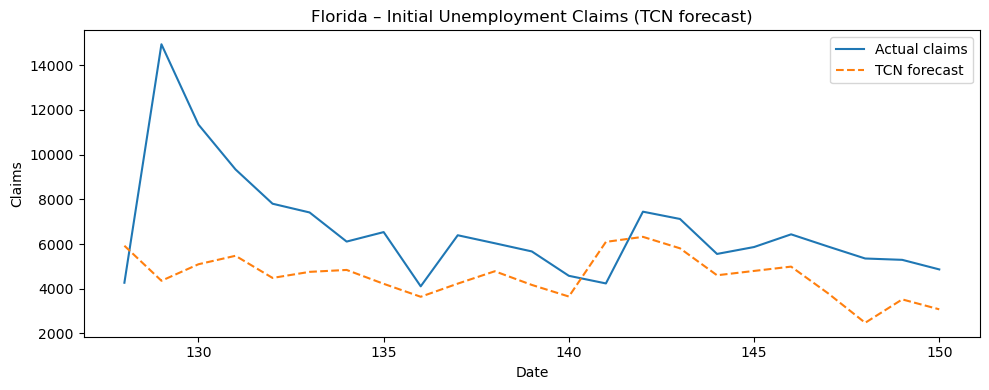

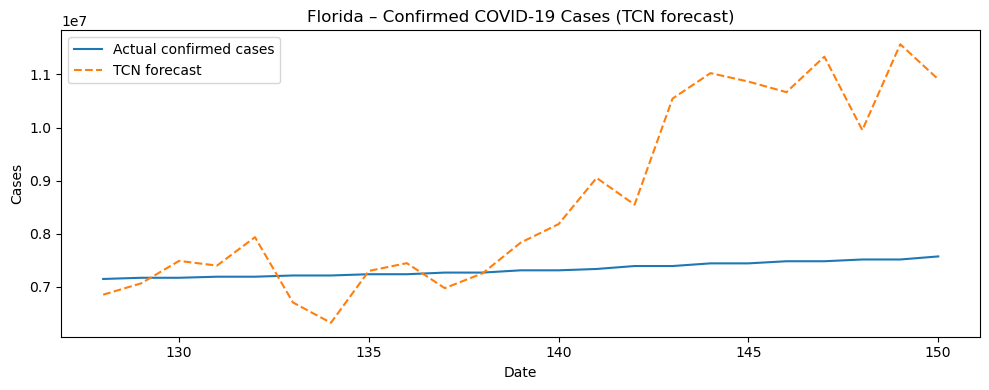

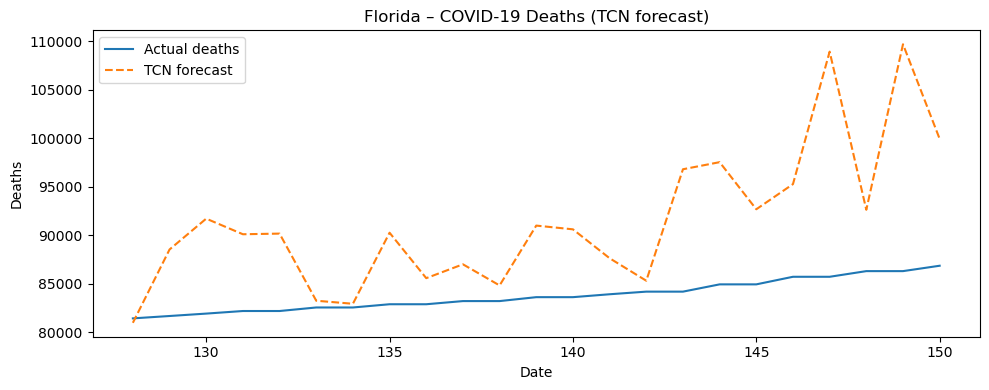

In [ ]:
# TCN UNIVARIATE FLORIDA

#Ahmed Mounir Elsemary


# Config
#HISTORY = 105 + 23     # number of past weeks model sees
#HORIZON = 23      # number of weeks ahead to forecast

HISTORY = 75
HORIZON = 23

"""
Train: (105, 10)
Val: (23, 10)
Test: (23, 10)
"""

# Load Florida combined dataset
df = pd.read_csv("Final_FL_CombinedData.csv")

# Ensure datetime column exists and is correct format
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"])
elif "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.rename(columns={"Date": "date"})
else:
    raise ValueError("No date column found in the dataset.")

# Sort data by date
df = df.sort_values("date").reset_index(drop=True)

CLAIMS_COL = "claims"
CASES_COL  = "Confirmed"
DEATHS_COL = "Deaths"

claims = df[CLAIMS_COL].astype(np.float32).values
cases  = df[CASES_COL].astype(np.float32).values
deaths = df[DEATHS_COL].astype(np.float32).values

# Train two separate TCNs: one for claims, one for confirmed cases
claims_train = claims[:-HORIZON]
cases_train  = cases[:-HORIZON]
deaths_train = deaths[:-HORIZON]

print("\nTraining TCN for unemployment claims")
model_claims, hist_claims = fit_tcn(
    claims_train,
    history_length=HISTORY,
    horizon=HORIZON,
    batch_size=32,
    num_epochs=30,
    learning_rate=1e-3,
)

print("\nTraining TCN for confirmed COVID-19 cases")
model_cases, hist_cases = fit_tcn(
    cases_train,
    history_length=HISTORY,
    horizon=HORIZON,
    batch_size=32,
    num_epochs=30,
    learning_rate=1e-3,
)

print("\nTraining TCN for COVID-19 deaths")
model_deaths, hist_deaths = fit_tcn(
    deaths_train,
    history_length=HISTORY,
    horizon=HORIZON,
    batch_size=32,
    num_epochs=30,
    learning_rate=1e-3,
)

# Build context windows to compare forecast vs actual on those held-out days
ctx_claims = claims[-(HISTORY + HORIZON) : -HORIZON]
ctx_cases  = cases[-(HISTORY + HORIZON) : -HORIZON]
ctx_deaths = deaths[-(HISTORY + HORIZON) : -HORIZON]

pred_claims = forecast(model_claims, ctx_claims)
pred_cases  = forecast(model_cases, ctx_cases)
pred_deaths = forecast(model_deaths, ctx_deaths)

# Ground truth for those last HORIZON days
future_dates = df.index[-HORIZON:]
true_claims  = claims[-HORIZON:]
true_cases   = cases[-HORIZON:]
true_deaths  = deaths[-HORIZON:]

# Plot: Claims
plt.figure(figsize=(10, 4))
plt.plot(future_dates, true_claims, label="Actual claims")
plt.plot(future_dates, pred_claims, "--", label="TCN forecast")
plt.title("Florida – Initial Unemployment Claims (TCN forecast)")
plt.xlabel("Date")
plt.ylabel("Claims")
plt.legend()
plt.tight_layout()

# Plot: Confirmed cases
plt.figure(figsize=(10, 4))
plt.plot(future_dates, true_cases, label="Actual confirmed cases")
plt.plot(future_dates, pred_cases, "--", label="TCN forecast")
plt.title("Florida – Confirmed COVID-19 Cases (TCN forecast)")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.legend()
plt.tight_layout()

# Plot: deaths
plt.figure(figsize=(10, 4))
plt.plot(future_dates, true_deaths, label="Actual deaths")
plt.plot(future_dates, pred_deaths, "--", label="TCN forecast")
plt.title("Florida – COVID-19 Deaths (TCN forecast)")
plt.xlabel("Date")
plt.ylabel("Deaths")
plt.legend()
plt.tight_layout()

plt.show()


In [34]:
def evaluate_performance(true, pred, model_name="Model"):
    mspe = mean_squared_error(true, pred)
    mae = mean_absolute_error(true, pred)
    mape = np.mean(np.abs((true - pred) / (true + 1e-6)))
    pm = (np.sum((true - pred) ** 2) / np.sum((true - np.mean(true)) ** 2))

    print(f"=== {model_name} Performance ===")
    print(f"MSPE: {mspe:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"PM:   {pm:.4f}")
    print("-" * 40)

    return mspe, mae, mape, pm

# Evaluate performance for each model
evaluate_performance(true_claims, pred_claims, model_name="TCN - Claims")
evaluate_performance(true_cases, pred_cases, model_name="TCN - Cases")
evaluate_performance(true_deaths, pred_deaths, model_name="TCN - Deaths")


=== TCN - Claims Performance ===
MSPE: 10115430.0000
MAE:  2369.0132
MAPE: 0.3251
PM:   1.7401
----------------------------------------
=== TCN - Cases Performance ===
MSPE: 4353686503424.0000
MAE:  1517877.0000
MAPE: 0.2041
PM:   263.1052
----------------------------------------
=== TCN - Deaths Performance ===
MSPE: 97317008.0000
MAE:  7716.4878
MAPE: 0.0913
PM:   39.5215
----------------------------------------


(97317008.0, 7716.48779296875, np.float32(0.091328934), np.float32(39.52145))

In [ ]:
# Don't run this part because, this is the part of the code we used in training and test our hyperparameters.
#Estifanos Zenebe
hidden_sizes      = [16, 64]
conv_hidden_sizes = [32, 128]
learning_rates    = [1e-3, 1e-4]
n_heads           = [2, 4]
encoder_layers    = [2, 4]
decoder_layers    = [2, 4]

top_models = [] 



for hidden_size in hidden_sizes:
    for conv_hidden_size in conv_hidden_sizes:
        for lr in learning_rates:
            for n_head in n_heads:
                for enc_layers in encoder_layers:
                    for dec_layers in decoder_layers:
                        model = Autoformer(
                            h=1,                      
                            input_size=36,             
                            hidden_size=hidden_size,
                            conv_hidden_size=conv_hidden_size,
                            n_head=n_head,
                            encoder_layers=enc_layers,
                            decoder_layers=dec_layers,
                            loss=MAE(),
                            
                            futr_exog_list=None,   
                            stat_exog_list=None,
                            
                            scaler_type='robust',
                            learning_rate=lr,
                            max_steps=200,
                            val_check_steps=50,
                            early_stop_patience_steps=2,
                            enable_progress_bar=False,
                            enable_model_summary=False,

                                )


                        nf = NeuralForecast(
                            models=[model],
                            freq='W'
                        )

                        nf.fit(df=train, val_size=len(val))

                        val_pred = nf.predict(df=val)

                        val_pred.head()

                        rolling_preds = []

                        for i in range(val.shape[0]):
                            # data available up to this point
                            df_until_now = pd.concat([train, val.iloc[:i]], axis=0)

                            # forecast 1 step ahead
                            pred_i = nf.predict(df=df_until_now)

                            # store prediction (align with actual val timestamp)
                            pred_i['ds'] = val.iloc[i]['ds']
                            rolling_preds.append(pred_i)

                        rolling_preds = pd.concat(rolling_preds).reset_index(drop=True)


                        val_plot = val.merge(
                            rolling_preds[['ds', 'Autoformer']],
                            on='ds',
                            how='left'
                        )

                        val_plot

                        model_name = (
                            f"AF_h{hidden_size}"
                            f"_c{conv_hidden_size}"
                            f"_lr{lr}"
                            f"_hd{n_head}"
                            f"_enc{enc_layers}"
                            f"_dec{dec_layers}"
                        )

                        #evaluate_performance(val_plot['y'],val_plot['Autoformer'], model_name="AutoFormer")
                        mspe, mae, mape, pm = evaluate_performance(
                            val_plot['y'],
                            val_plot['Autoformer'],
                            model_name= model_name
                        )

                        result = {
                            'hidden_size': hidden_size,
                            'conv_hidden_size': conv_hidden_size,
                            'lr': lr,
                            'n_head': n_head,
                            'enc_layers' :enc_layers,
                            'dec_layers' : dec_layers,
                            'mspe': mspe,
                            'mae': mae,
                            'mape': mape,
                            'pm': pm
                        }

                        top_models.append(result)

                        
# Sort by MAE and keep only top 3
top_models = sorted(top_models, key=lambda x: x['mae'])[:3]
print("\n=== TOP 3 AUTOFORMER MODELS BY MAE ===")

for rank, model in enumerate(top_models, start=1):
    print(f"\n# {rank}")
    for k, v in model.items():
        print(f"{k}: {v}")



In [ ]:


#FinalFloridaCombinedData = results['FL']
FinalFloridaCombinedData = pd.read_csv("Final_FL_CombinedData.csv")
FinalFloridaCombinedData = FinalFloridaCombinedData[['Date', 'claims', 'Confirmed', 'Deaths', 'Active']]
FinalFloridaCombinedData.head()

,Date,claims,Confirmed,Deaths,Active
0,2020-04-18,506670.0,25492.0,748.0,NaN
1,2020-04-25,433103.0,30839.0,1055.0,NaN
2,2020-05-02,174860.0,35463.0,1364.0,34099.0
3,2020-05-09,223082.0,40001.0,1715.0,NaN
4,2020-05-16,225404.0,44811.0,1964.0,NaN


In [ ]:


#FinalFloridaCombinedData = results['FL']
#FinalFloridaCombinedData = pd.read_csv("Final_FL_CombinedData.csv")
#Estifanos Zenebe

df = FinalFloridaCombinedData.copy()
df['ds'] = df.index
df['unique_id'] = 'series_1'
df = df.rename(columns=lambda x: x.strip())  
try:
    df = df.drop(columns=['Unnamed: 0'])  
except:
    x =1 

df['ds'] = pd.to_datetime(df['Date'])
df = df.drop(columns=['Date'])
df['ds'] = pd.to_datetime(df['ds'].dt.date)

# Sometimes the first day is excluded; shift +1 day
df['ds'] = pd.to_datetime(df['ds']) + pd.to_timedelta(1, unit='D')

# Target column claims:
#df = df.rename(columns={'claims': 'y'})

# Target column 'Confirmed'
df = df.rename(columns={'Confirmed': 'y'})

# Target column 'Deaths'
#df = df.rename(columns={'Deaths': 'y'})


df = df.drop(columns=['Active'])
# FUTURE EXOGENOUS VARIABLES
futr_cols = ['Deaths', 'Confirmed']  


n = len(df)
train = df.iloc[:int(n*0.7)]
val   = df.iloc[int(n*0.7):int(n*0.85)]
test  = df.iloc[int(n*0.85):]

print("Train:", train.shape)
print("Val:",   val.shape)
print("Test:",  test.shape)

train.head()

Train: (105, 5)
Val: (23, 5)
Test: (23, 5)


,claims,y,Deaths,ds,unique_id
0,506670.0,25492.0,748.0,2020-04-19,series_1
1,433103.0,30839.0,1055.0,2020-04-26,series_1
2,174860.0,35463.0,1364.0,2020-05-03,series_1
3,223082.0,40001.0,1715.0,2020-05-10,series_1
4,225404.0,44811.0,1964.0,2020-05-17,series_1


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU 

=== AF_h16_c128_lr0.0001_hd4_enc4_dec4 Performance ===
MSPE: 211937205173.9891
MAE:  296940.7609
MAPE: 0.0409
PM:   12.8079
----------------------------------------
AF_h16_c128_lr0.0001_hd4_enc4_dec4
MSPE: 211937205173.98914
MAE: 296940.76086956525
MAPE: 0.04089349757758402
PM: 12.807944181940021


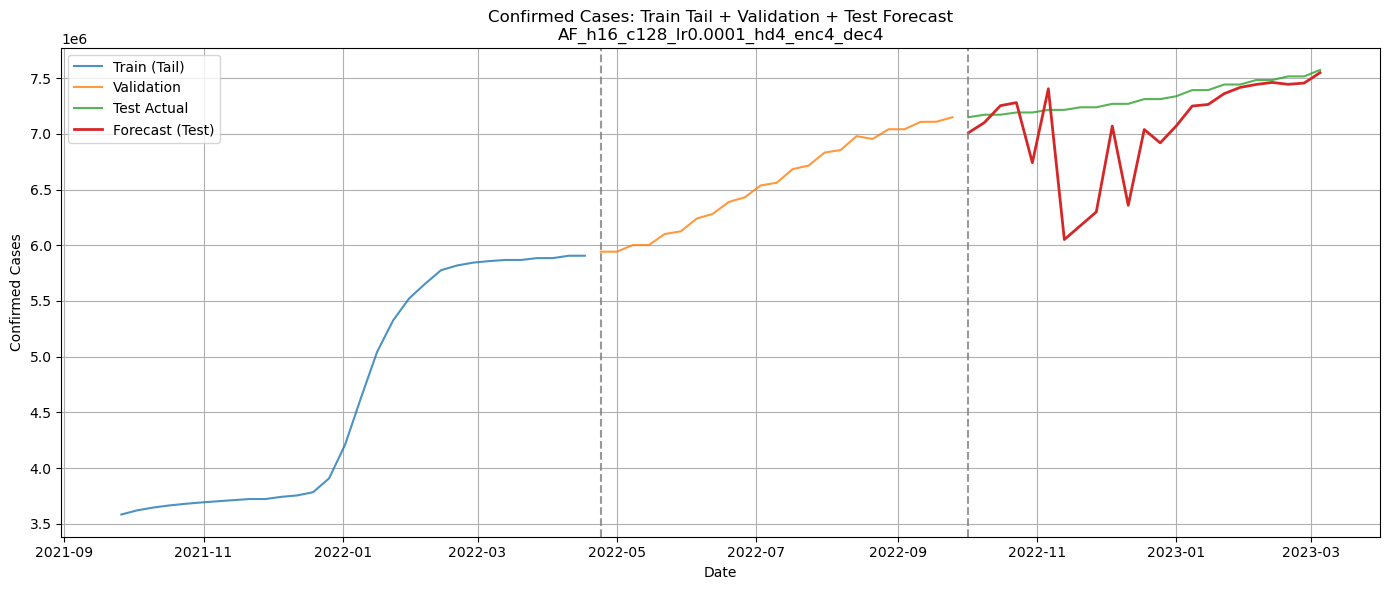

"\n# FOR DEATHS\n# ================= PLOT: LAST TRAIN + VAL + TEST (Deaths) =================\nlast_n_train = 30\ntrain_zoom = train.iloc[-last_n_train:]\n\nplt.figure(figsize=(14, 6))\n\n# Actual segments\nplt.plot(train_zoom['ds'], train_zoom['y'], label='Train Deaths (Tail)', alpha=0.8)\nplt.plot(val['ds'], val['y'], label='Validation Deaths', alpha=0.8)\nplt.plot(test['ds'], test['y'], label='Test Actual Deaths', alpha=0.8)\n\n# Forecast\nplt.plot(test_forecast['ds'], test_forecast['Autoformer'],\n         label='Forecasted Deaths (Test)', linewidth=2)\n\n# Confidence Intervals\nif 'Autoformer-lo-90' in rolling_preds.columns:\n    merged_ci = test.merge(\n        rolling_preds[['ds', 'Autoformer-lo-90', 'Autoformer-hi-90']],\n        on='ds', how='left'\n    )\n    plt.fill_between(\n        merged_ci['ds'],\n        merged_ci['Autoformer-lo-90'],\n        merged_ci['Autoformer-hi-90'],\n        alpha=0.2, label='90% CI (Deaths)'\n    )\n\nplt.axvline(val['ds'].iloc[0], linestyle='

In [ ]:
# AUTOFORMER MODEL
#Estifanos Zenebe

# Package Versions Used
# neuralforecast: 1.7.4
# utilsforecast: 0.2.14
# Python: 3.10.19

#We Did a grid search using COLAB T4 GPU




# Hyper parameter Check 

"""
hidden_sizes = [8, 16, 32, 64, 128]
conv_hidden_sizes = [16, 32, 64, 128, 256]
learning_rates = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
n_heads = [1, 2, 4, 8, 16]
encoder_layers = [1, 2, 3, 4, 6]
decoder_layers = [1, 2, 3, 4, 6]
"""


"""
=== TOP 3 AUTOFORMER MODELS BY MAE ===

# 1
hidden_size: 16
conv_hidden_size: 128
lr: 0.0001
n_head: 4
enc_layers: 4
dec_layers: 4
mspe: 1827463.5054851745
mae: 1087.5776685631793
mape: 0.17673068714031312
pm: 2.2589641080201557

# 2
hidden_size: 16
conv_hidden_size: 128
lr: 0.0001
n_head: 2
enc_layers: 4
dec_layers: 4
mspe: 1835138.4781292807
mae: 1094.8162470278533
mape: 0.17799333112702048
pm: 2.268451294867408

# 3
hidden_size: 64
conv_hidden_size: 128
lr: 0.0001
n_head: 2
enc_layers: 2
dec_layers: 2
mspe: 2176483.54390021
mae: 1216.295749830163
mape: 0.19870637896432275
pm: 2.6903947425542567


"""


# Predict on test set 

# Hyperparameters
hidden_size = 16
conv_hidden_size = 128
lr = 0.0001
n_head = 4
enc_layers = 4
dec_layers = 4

# Define Model
model = Autoformer(
    h=1,
    input_size=36,
    hidden_size=hidden_size,
    conv_hidden_size=conv_hidden_size,
    n_head=n_head,
    encoder_layers=enc_layers,
    decoder_layers=dec_layers,
    loss=MAE(),
    futr_exog_list=None,
    stat_exog_list=None,
    
    #hist_exog_list = ,
    scaler_type='robust',
    learning_rate=lr,
    max_steps=200,
    val_check_steps=50,
    early_stop_patience_steps=2,
    enable_progress_bar=False,
    enable_model_summary=False,
)

nf = NeuralForecast(models=[model], freq='W')
nf.fit(df=train, val_size=len(val))  

rolling_preds = []

for i in range(test.shape[0]):
    hist_df = pd.concat([train, val, test.iloc[:i]], axis=0)

    pred_i = nf.predict(df=hist_df)
    pred_i['ds'] = test.iloc[i]['ds']  

    rolling_preds.append(pred_i)

rolling_preds = pd.concat(rolling_preds).reset_index(drop=True)

# Merge Predictions with TEST Truth
test_forecast = test.merge(
    rolling_preds[['ds', 'Autoformer']],
    on='ds',
    how='left'
)

model_name = (
    f"AF_h{hidden_size}"
    f"_c{conv_hidden_size}"
    f"_lr{lr}"
    f"_hd{n_head}"
    f"_enc{enc_layers}"
    f"_dec{dec_layers}"
)

# Evaluate ON TEST ONLY
mspe, mae, mape, pm = evaluate_performance(
    test_forecast['y'],
    test_forecast['Autoformer'],
    model_name=model_name
)

print(model_name)
print("MSPE:", mspe)
print("MAE:", mae)
print("MAPE:", mape)
print("PM:", pm)

test_forecast.head()

"""
# ================= PLOT: LAST TRAIN + VAL + TEST =================
last_n_train = 30 

train_zoom = train.iloc[-last_n_train:]

plt.figure(figsize=(14, 6))

# Actual segments
plt.plot(train_zoom['ds'], train_zoom['y'], label='Train (Tail)', alpha=0.8)
plt.plot(val['ds'], val['y'], label='Validation', alpha=0.8)
plt.plot(test['ds'], test['y'], label='Test Actual', alpha=0.8)

# Forecast
plt.plot(test_forecast['ds'], test_forecast['Autoformer'],
         label='Forecast (Test)',
         linewidth=2)


# Confidence Intervals 
if 'Autoformer-lo-90' in rolling_preds.columns:
    merged_ci = test.merge(
        rolling_preds[['ds', 'Autoformer-lo-90', 'Autoformer-hi-90']],
        on='ds', how='left'
    )
    plt.fill_between(
        merged_ci['ds'],
        merged_ci['Autoformer-lo-90'],
        merged_ci['Autoformer-hi-90'],
        alpha=0.2, label='90% CI'
    )

plt.axvline(val['ds'].iloc[0], linestyle='--', color='gray', alpha=0.8)
plt.axvline(test['ds'].iloc[0], linestyle='--', color='gray', alpha=0.8)

plt.title(f'Train Tail + Val + Test Forecast\n{model_name}')
plt.xlabel('Date')
plt.ylabel('Claims')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

"""
#FOR CONFIRMED CASES
# ================= PLOT: LAST TRAIN + VAL + TEST =================
last_n_train = 30
train_zoom = train.iloc[-last_n_train:]

plt.figure(figsize=(14, 6))

# Actual segments
plt.plot(train_zoom['ds'], train_zoom['y'], label='Train (Tail)', alpha=0.8)
plt.plot(val['ds'], val['y'], label='Validation', alpha=0.8)
plt.plot(test['ds'], test['y'], label='Test Actual', alpha=0.8)

# Forecast
plt.plot(test_forecast['ds'], test_forecast['Autoformer'],
         label='Forecast (Test)', linewidth=2)

# Confidence Intervals
if 'Autoformer-lo-90' in rolling_preds.columns:
    merged_ci = test.merge(
        rolling_preds[['ds', 'Autoformer-lo-90', 'Autoformer-hi-90']],
        on='ds', how='left'
    )
    plt.fill_between(
        merged_ci['ds'],
        merged_ci['Autoformer-lo-90'],
        merged_ci['Autoformer-hi-90'],
        alpha=0.2, label='90% CI'
    )

plt.axvline(val['ds'].iloc[0], linestyle='--', color='gray', alpha=0.8)
plt.axvline(test['ds'].iloc[0], linestyle='--', color='gray', alpha=0.8)

# Updated labels
plt.title(f'Confirmed Cases: Train Tail + Validation + Test Forecast\n{model_name}')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Train: (105, 5)
Val: (23, 5)
Test: (23, 5)


`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: Fal

=== AF_h16_c128_lr0.0001_hd4_enc4_dec4 Performance ===
MSPE: 12599680.8996
MAE:  2610.7087
MAPE: 0.3374
PM:   2.1674
----------------------------------------
AF_h16_c128_lr0.0001_hd4_enc4_dec4
MSPE: 12599680.899616193
MAE: 2610.708697775136
MAPE: 0.33738787725354724
PM: 2.1674231065041316


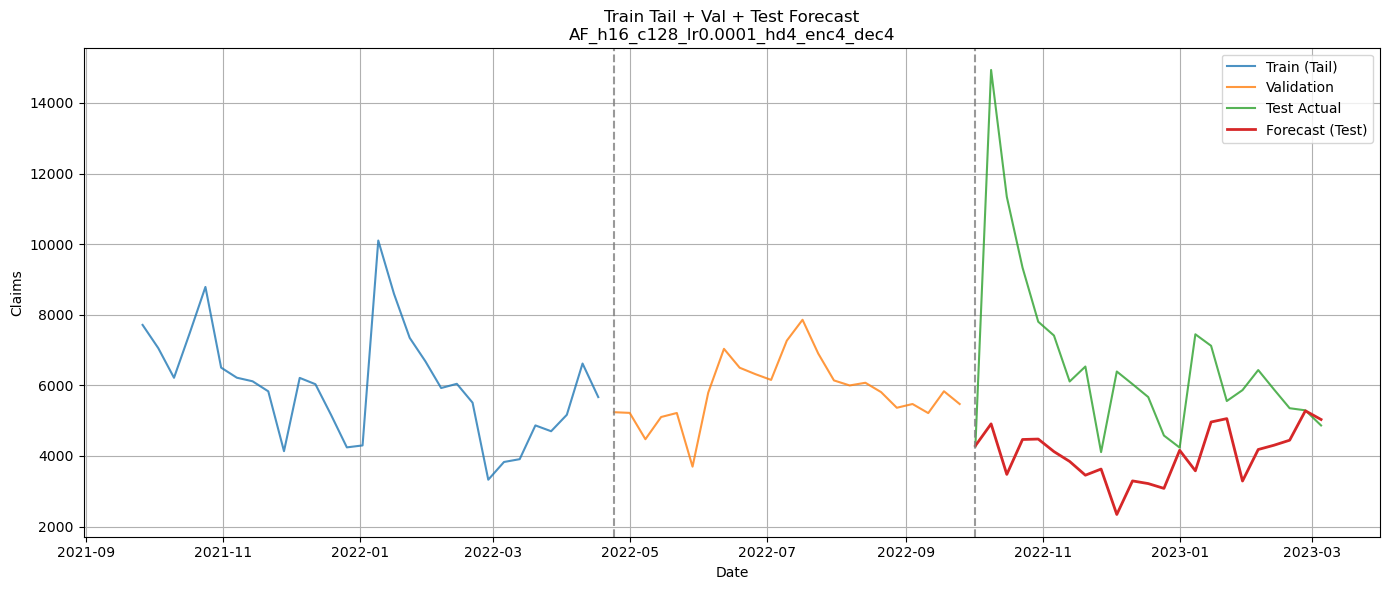

In [40]:


#FinalFloridaCombinedData = results['FL']
#FinalFloridaCombinedData = pd.read_csv("Final_FL_CombinedData.csv")


df = FinalFloridaCombinedData.copy()
df['ds'] = df.index
df['unique_id'] = 'series_1'
df = df.rename(columns=lambda x: x.strip())  
try:
    df = df.drop(columns=['Unnamed: 0'])  
except:
    x =1 

df['ds'] = pd.to_datetime(df['Date'])
df = df.drop(columns=['Date'])
df['ds'] = pd.to_datetime(df['ds'].dt.date)

# Sometimes the first day is excluded; shift +1 day
df['ds'] = pd.to_datetime(df['ds']) + pd.to_timedelta(1, unit='D')

# Target column claims:
df = df.rename(columns={'claims': 'y'})

# Target column 'Confirmed'
#df = df.rename(columns={'Confirmed': 'y'})

# Target column 'Deaths'
#df = df.rename(columns={'Deaths': 'y'})


df = df.drop(columns=['Active'])
# FUTURE EXOGENOUS VARIABLES
futr_cols = ['Deaths', 'Confirmed']  


n = len(df)
train = df.iloc[:int(n*0.7)]
val   = df.iloc[int(n*0.7):int(n*0.85)]
test  = df.iloc[int(n*0.85):]

print("Train:", train.shape)
print("Val:",   val.shape)
print("Test:",  test.shape)

train.head()


# Predict on test set 

# Hyperparameters
hidden_size = 16
conv_hidden_size = 128
lr = 0.0001
n_head = 4
enc_layers = 4
dec_layers = 4

# Define Model
model = Autoformer(
    h=1,
    input_size=36,
    hidden_size=hidden_size,
    conv_hidden_size=conv_hidden_size,
    n_head=n_head,
    encoder_layers=enc_layers,
    decoder_layers=dec_layers,
    loss=MAE(),
    futr_exog_list=None,
    stat_exog_list=None,
    
    #hist_exog_list = ,
    scaler_type='robust',
    learning_rate=lr,
    max_steps=200,
    val_check_steps=50,
    early_stop_patience_steps=2,
    enable_progress_bar=False,
    enable_model_summary=False,
)

nf = NeuralForecast(models=[model], freq='W')
nf.fit(df=train, val_size=len(val))  

rolling_preds = []

for i in range(test.shape[0]):
    hist_df = pd.concat([train, val, test.iloc[:i]], axis=0)

    pred_i = nf.predict(df=hist_df)
    pred_i['ds'] = test.iloc[i]['ds']  

    rolling_preds.append(pred_i)

rolling_preds = pd.concat(rolling_preds).reset_index(drop=True)

# Merge Predictions with TEST Truth
test_forecast = test.merge(
    rolling_preds[['ds', 'Autoformer']],
    on='ds',
    how='left'
)

model_name = (
    f"AF_h{hidden_size}"
    f"_c{conv_hidden_size}"
    f"_lr{lr}"
    f"_hd{n_head}"
    f"_enc{enc_layers}"
    f"_dec{dec_layers}"
)

# Evaluate ON TEST ONLY
mspe, mae, mape, pm = evaluate_performance(
    test_forecast['y'],
    test_forecast['Autoformer'],
    model_name=model_name
)

print(model_name)
print("MSPE:", mspe)
print("MAE:", mae)
print("MAPE:", mape)
print("PM:", pm)

test_forecast.head()


# ================= PLOT: LAST TRAIN + VAL + TEST =================
last_n_train = 30 

train_zoom = train.iloc[-last_n_train:]

plt.figure(figsize=(14, 6))

# Actual segments
plt.plot(train_zoom['ds'], train_zoom['y'], label='Train (Tail)', alpha=0.8)
plt.plot(val['ds'], val['y'], label='Validation', alpha=0.8)
plt.plot(test['ds'], test['y'], label='Test Actual', alpha=0.8)

# Forecast
plt.plot(test_forecast['ds'], test_forecast['Autoformer'],
         label='Forecast (Test)',
         linewidth=2)


# Confidence Intervals 
if 'Autoformer-lo-90' in rolling_preds.columns:
    merged_ci = test.merge(
        rolling_preds[['ds', 'Autoformer-lo-90', 'Autoformer-hi-90']],
        on='ds', how='left'
    )
    plt.fill_between(
        merged_ci['ds'],
        merged_ci['Autoformer-lo-90'],
        merged_ci['Autoformer-hi-90'],
        alpha=0.2, label='90% CI'
    )

plt.axvline(val['ds'].iloc[0], linestyle='--', color='gray', alpha=0.8)
plt.axvline(test['ds'].iloc[0], linestyle='--', color='gray', alpha=0.8)

plt.title(f'Train Tail + Val + Test Forecast\n{model_name}')
plt.xlabel('Date')
plt.ylabel('Claims')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Train: (105, 5)
Val: (23, 5)
Test: (23, 5)


`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
GPU available: False, used: False
TPU available: Fal

=== AF_h16_c128_lr0.0001_hd4_enc4_dec4 Performance ===
MSPE: 14920717.5403
MAE:  2736.6722
MAPE: 0.0330
PM:   6.0595
----------------------------------------
AF_h16_c128_lr0.0001_hd4_enc4_dec4
MSPE: 14920717.540338932
MAE: 2736.672214673913
MAPE: 0.03296464293444122
PM: 6.059458689985823


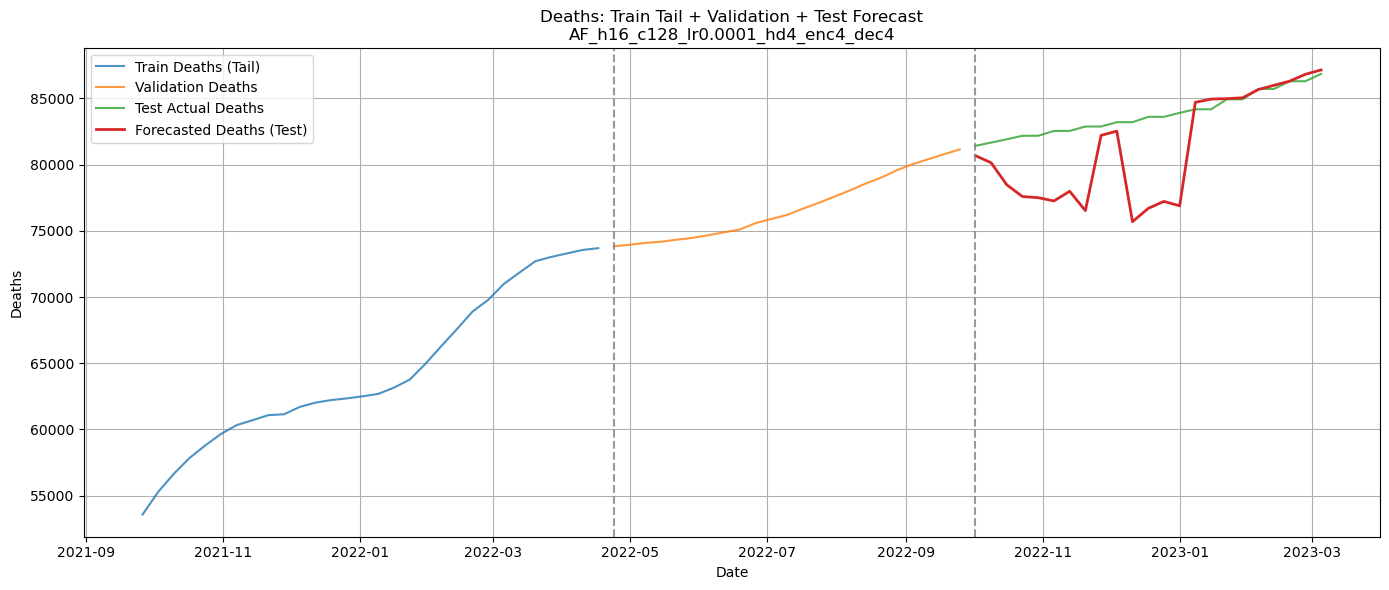

In [ ]:
#Estifanos Zenebe
df = FinalFloridaCombinedData.copy()
df['ds'] = df.index
df['unique_id'] = 'series_1'
df = df.rename(columns=lambda x: x.strip())  
try:
    df = df.drop(columns=['Unnamed: 0'])  
except:
    x =1 

df['ds'] = pd.to_datetime(df['Date'])
df = df.drop(columns=['Date'])
df['ds'] = pd.to_datetime(df['ds'].dt.date)

# Sometimes the first day is excluded; shift +1 day
df['ds'] = pd.to_datetime(df['ds']) + pd.to_timedelta(1, unit='D')

# Target column claims:
#df = df.rename(columns={'claims': 'y'})

# Target column 'Confirmed'
#df = df.rename(columns={'Confirmed': 'y'})

# Target column 'Deaths'
df = df.rename(columns={'Deaths': 'y'})


df = df.drop(columns=['Active'])
# FUTURE EXOGENOUS VARIABLES
futr_cols = ['Deaths', 'Confirmed']  


n = len(df)
train = df.iloc[:int(n*0.7)]
val   = df.iloc[int(n*0.7):int(n*0.85)]
test  = df.iloc[int(n*0.85):]

print("Train:", train.shape)
print("Val:",   val.shape)
print("Test:",  test.shape)

train.head()


# Predict on test set 

# Hyperparameters
hidden_size = 16
conv_hidden_size = 128
lr = 0.0001
n_head = 4
enc_layers = 4
dec_layers = 4

# Define Model
model = Autoformer(
    h=1,
    input_size=36,
    hidden_size=hidden_size,
    conv_hidden_size=conv_hidden_size,
    n_head=n_head,
    encoder_layers=enc_layers,
    decoder_layers=dec_layers,
    loss=MAE(),
    futr_exog_list=None,
    stat_exog_list=None,
    
    #hist_exog_list = ,
    scaler_type='robust',
    learning_rate=lr,
    max_steps=200,
    val_check_steps=50,
    early_stop_patience_steps=2,
    enable_progress_bar=False,
    enable_model_summary=False,
)

nf = NeuralForecast(models=[model], freq='W')
nf.fit(df=train, val_size=len(val))  

rolling_preds = []

for i in range(test.shape[0]):
    hist_df = pd.concat([train, val, test.iloc[:i]], axis=0)

    pred_i = nf.predict(df=hist_df)
    pred_i['ds'] = test.iloc[i]['ds']  

    rolling_preds.append(pred_i)

rolling_preds = pd.concat(rolling_preds).reset_index(drop=True)

# Merge Predictions with TEST Truth
test_forecast = test.merge(
    rolling_preds[['ds', 'Autoformer']],
    on='ds',
    how='left'
)

model_name = (
    f"AF_h{hidden_size}"
    f"_c{conv_hidden_size}"
    f"_lr{lr}"
    f"_hd{n_head}"
    f"_enc{enc_layers}"
    f"_dec{dec_layers}"
)

# Evaluate ON TEST ONLY
mspe, mae, mape, pm = evaluate_performance(
    test_forecast['y'],
    test_forecast['Autoformer'],
    model_name=model_name
)

print(model_name)
print("MSPE:", mspe)
print("MAE:", mae)
print("MAPE:", mape)
print("PM:", pm)

test_forecast.head()



# FOR DEATHS
# ================= PLOT: LAST TRAIN + VAL + TEST (Deaths) =================
last_n_train = 30
train_zoom = train.iloc[-last_n_train:]

plt.figure(figsize=(14, 6))

# Actual segments
plt.plot(train_zoom['ds'], train_zoom['y'], label='Train Deaths (Tail)', alpha=0.8)
plt.plot(val['ds'], val['y'], label='Validation Deaths', alpha=0.8)
plt.plot(test['ds'], test['y'], label='Test Actual Deaths', alpha=0.8)

# Forecast
plt.plot(test_forecast['ds'], test_forecast['Autoformer'],
         label='Forecasted Deaths (Test)', linewidth=2)

# Confidence Intervals
if 'Autoformer-lo-90' in rolling_preds.columns:
    merged_ci = test.merge(
        rolling_preds[['ds', 'Autoformer-lo-90', 'Autoformer-hi-90']],
        on='ds', how='left'
    )
    plt.fill_between(
        merged_ci['ds'],
        merged_ci['Autoformer-lo-90'],
        merged_ci['Autoformer-hi-90'],
        alpha=0.2, label='90% CI (Deaths)'
    )

plt.axvline(val['ds'].iloc[0], linestyle='--', color='gray', alpha=0.8)
plt.axvline(test['ds'].iloc[0], linestyle='--', color='gray', alpha=0.8)

# Updated labels for Deaths
plt.title(f'Deaths: Train Tail + Validation + Test Forecast\n{model_name}')
plt.xlabel('Date')
plt.ylabel('Deaths')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
